In [1]:
import uproot
import ROOT as r
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import awkward as ak
import array as arr
import pandas as pd
import os
import sys

notebook_dir = '/nashome/m/micarrig/icarus/pmt/v10_06_00_01p04'
if notebook_dir not in sys.path:
    sys.path.insert(0, notebook_dir)

# Now you can import from getPMTRecal.py
from getPMTRecal import *

Welcome to JupyROOT 6.30/02


In [ ]:
class runInfo:
    def __init__(self\t run_number):
        self.run_number = run_number
        self.totalMean = -1
        self.totalMeanErr = -1
        self.totalStd = -1
        self.totalStdErr = -1
        self.totalRecalMean = -1
        self.totalRecalMeanErr = -1
        self.totalRecalStd = -1
        self.totalRecalStdErr = -1
        self.totalFitMean = -1
        self.totalFitMeanErr = -1
        self.totalFitStd = -1
        self.totalFitStdErr = -1
        self.totalFitStatus = -1
        self.totalRecalFitStatus = -1
        self.totalFitRecalFitStatus = -1
        self.meanPMT = []
        self.meanPMTErr = []
        self.stdPMT = []
        self.stdPMTErr = []
        self.recalMeanPMT = []
        self.recalMeanPMTErr = []
        self.recalStdPMT = []
        self.recalStdPMTErr = []
        self.fitMeanPMT = []
        self.fitMeanPMTErr = []
        self.fitStdPMT = []
        self.fitStdPMTErr = []
        self.fitStatusPMT = []
        self.recalFitStatusPMT = []
        self.fitRecalFitStatusPMT = []
    

plotDirs = ['NormalizedPE', 'RecalibratedPE', 'RecalibratedFitPE', 'SumPE', "SumPERecal", "SumPEFitRecal"]
#fin = r.TFile.Open("/nashome/m/micarrig/icarus/pmt/v10_06_00_01p04/pmtPEHistograms.root", "READ")
#fin = r.TFile.Open("/nashome/m/micarrig/icarus/pmt/v10_06_00_01p04/pmtRecalTest/pmtPEHistograms.root", "READ") # test version, only channel 25
fin = r.TFile.Open("/nashome/m/micarrig/icarus/pmt/v10_06_00_01p04/pmtRecalNoFlash/pmtPEHistograms.root", "READ") # histograms with no flash matching

runInfos = []

fit = True

# Get list of run directories from the ROOT file
run_directories = []
keys = fin.GetListOfKeys()
for key in keys:
    if key.GetName().startswith("run"):
        run_directories.append(key.GetName())

print(f"Found {len(run_directories)} run directories: {run_directories}")

for run in run_directories:
    print(f"Processing histograms for {run}...")
    dir = fin.GetDirectory(run)
    
    runInfo_ = runInfo(run_number=int(run.replace('run', '')))

    for plotDir in plotDirs:
        subdir = dir.GetDirectory(plotDir)
        if not subdir:
            print(f"Directory {plotDir} not found in {run}, skipping...")
            continue
        if 'Sum' not in plotDir:
            continue
        for ipmt in subdir.GetListOfKeys():
            mean = -1
            std = -1
            meanErr = -1
            stdErr = -1
            fitStatus = -1
            hist = subdir.Get(ipmt.GetName())
            if fit == True:
                if hist.Integral(hist.FindFixBin(0), hist.FindFixBin(2)) > 0 or 'Sum' in plotDir: 

                    if 'Sum' in plotDir:
                        fitLow = 0
                        fitHigh = 50e5
                        f = r.TF1("f", "gaus", fitLow, fitHigh)
                        f.SetParameters(10, 25e4, 10e3)
                    else:
                        fitLow = 0
                        fitHigh = 2
                        f = r.TF1("f", "[0]*TMath::Power(([1]/[2]),(x/[2]))*(TMath::Exp(-([1]/[2])))/TMath::Gamma((x/[2])+1.)", fitLow, fitHigh)
                        f.SetParameters(10, 0.1, 0.2)
                    fitResult = hist.Fit(f, "EMRNQS", "", fitLow, fitHigh)
                    mean = f.GetParameter(1)
                    std = f.GetParameter(2)
                    meanErr = f.GetParError(1)
                    stdErr = f.GetParError(2)
                    try:
                        fitStatus = fitResult.Get().Status()
                    except:
                        fitStatus = -1
                    #print(f"Fitted PMT {ipmt.GetName()} in {plotDir} of {run}: mean = {mean} ± {meanErr}, std = {std} ± {stdErr}")

            else:
                mean = hist.GetMean()
                std = hist.GetStdDev()
                meanErr = hist.GetMeanError()
                stdErr = hist.GetStdDevError()
                fitStatus = 0
            if plotDir == 'NormalizedPE':
                runInfo_.meanPMT.append(mean)
                runInfo_.stdPMT.append(std)
                runInfo_.meanPMTErr.append(meanErr)
                runInfo_.stdPMTErr.append(stdErr)
                runInfo_.fitStatusPMT.append(fitStatus)
            elif plotDir == 'RecalibratedPE':
                runInfo_.recalMeanPMT.append(mean)
                runInfo_.recalStdPMT.append(std)
                runInfo_.recalMeanPMTErr.append(meanErr)
                runInfo_.recalStdPMTErr.append(stdErr)
                runInfo_.recalFitStatusPMT.append(fitStatus)
            elif plotDir == 'SumPE':
                runInfo_.totalMean = mean
                runInfo_.totalStd = std
                runInfo_.totalMeanErr = meanErr
                runInfo_.totalStdErr = stdErr
                runInfo_.totalFitStatus = fitStatus
            elif plotDir == 'SumPERecal':
                runInfo_.totalRecalMean = mean
                runInfo_.totalRecalStd = std
                runInfo_.totalRecalMeanErr = meanErr
                runInfo_.totalRecalStdErr = stdErr
                runInfo_.totalRecalFitStatus = fitStatus
            elif plotDir == 'RecalibratedFitPE':
                runInfo_.fitMeanPMT.append(mean)
                runInfo_.fitStdPMT.append(std)
                runInfo_.fitMeanPMTErr.append(meanErr)
                runInfo_.fitStdPMTErr.append(stdErr)
                runInfo_.fitRecalFitStatusPMT.append(fitStatus)
            elif plotDir == 'SumPEFitRecal':
                runInfo_.totalFitMean = mean
                runInfo_.totalFitStd = std
                runInfo_.totalFitMeanErr = meanErr
                runInfo_.totalFitStdErr = stdErr
                runInfo_.totalFitRecalFitStatus = fitStatus
    runInfos.append(runInfo_)

runInfos.sort(key=lambda x: x.run_number)



In [3]:
def plotPE_total(runInfos, fout):
    c1 = r.TCanvas("c1", "Total PE Mean vs Run", 1200, 600)
    c1.SetGrid()
    g_totalMean = r.TGraphErrors()
    g_totalRecalMean = r.TGraphErrors()

    for i, info in enumerate(runInfos):
        run = info.run_number
        print(f"Run {run}: Total Mean = {info.totalMean} ± {info.totalMeanErr}, Total Recal Mean = {info.totalRecalMean} ± {info.totalRecalMeanErr}")
        g_totalMean.SetPoint(i, run, info.totalMean)
        g_totalMean.SetPointError(i, 0, info.totalMeanErr)
        g_totalRecalMean.SetPoint(i, run, info.totalRecalMean)
        g_totalRecalMean.SetPointError(i, 0, info.totalRecalMeanErr)

    g_totalMean.SetMarkerColor(r.kBlue+2)
    g_totalMean.SetTitle("Total PE Mean vs Run;Run Number;Total PE Mean")
    g_totalMean.SetMarkerStyle(20)
    g_totalRecalMean.SetMarkerStyle(21)
    g_totalMean.SetMarkerSize(0.5)
    g_totalRecalMean.SetMarkerSize(0.5)
    g_totalRecalMean.SetMarkerColor(r.kRed+2)

    g_totalMean.GetYaxis().SetRangeUser(1.5e4, 3e4)

    g_totalMean.Draw("AP")
    g_totalRecalMean.Draw("P same")

    f_mean = r.TF1("f_mean", "[0]+x*[1]", g_totalMean.GetXaxis().GetXmin(), g_totalMean.GetXaxis().GetXmax())
    f_meanRecal = r.TF1("f_meanRecal", "[0]+x*[1]", g_totalRecalMean.GetXaxis().GetXmin(), g_totalRecalMean.GetXaxis().GetXmax())
    g_totalMean.Fit(f_mean, "blmn")
    g_totalRecalMean.Fit(f_meanRecal, "blmn")

    f_mean.SetLineColor(r.kBlue)
    f_meanRecal.SetLineColor(r.kRed)
    f_mean.SetLineWidth(2)
    f_meanRecal.SetLineWidth(2)
    f_mean.Draw("same")
    f_meanRecal.Draw("same")

    slopeMean = f_mean.GetParameter(1)
    slopeMeanRecal = f_meanRecal.GetParameter(1)

    l1 = r.TLegend(0.35, 0.35, 0.55, 0.55)
    l1.AddEntry(g_totalMean, f"Original: slope={slopeMean:.2f}", "pl")
    l1.AddEntry(g_totalRecalMean, f"Recal: slope={slopeMeanRecal:.2f}", "pl")
    l1.Draw()

    fout.cd()
    fout.cd("totalPlots")
    c1.Write()
    g_totalMean.Write("totalMean")
    g_totalRecalMean.Write("totalMeanRecal")

In [4]:
def plotPE_PMT(runInfos, chan, fout, df, gains=None, gainsErr=None):

    c1 = r.TCanvas("c1", f"Channel {chan} PE Mean vs Run", 1200, 600)
    c1.SetGrid()
    # Add some margin on the right for the second axis
    c1.SetRightMargin(0.12)

    setyMin = 0
    setyMax = 2

    g_meanPMT = r.TGraphErrors()
    g_recalMeanPMT = r.TGraphErrors()
    g_meanPMTFit = r.TGraphErrors()

    speRuns = [r.TLine(run, setyMin, run, setyMax) for run in speFiles.keys() if run < 10000]

    ptOrig, ptRecal, ptFit = 0, 0, 0
    for i, info in enumerate(runInfos):
        run = info.run_number
        if run in bad_runs: continue
        if info.meanPMT[chan] > 0 and info.meanPMTErr[chan] > 0: 
            if info.meanPMTErr[chan] > 0.1: continue
            g_meanPMT.SetPoint(ptOrig, run, info.meanPMT[chan])
            g_meanPMT.SetPointError(ptOrig, 0, info.meanPMTErr[chan])
            ptOrig += 1
        if info.recalMeanPMT[chan] > 0 and info.recalMeanPMTErr[chan] > 0:
            if info.recalMeanPMTErr[chan] > 0.1: continue
            g_recalMeanPMT.SetPoint(ptRecal, run, info.recalMeanPMT[chan])
            g_recalMeanPMT.SetPointError(ptRecal, 0, info.recalMeanPMTErr[chan])
            ptRecal += 1
        if info.fitMeanPMT[chan] > 0 and info.fitMeanPMTErr[chan] > 0: 
            if info.fitMeanPMTErr[chan] > 0.1: continue
            g_meanPMTFit.SetPoint(ptFit, run, info.fitMeanPMT[chan])
            g_meanPMTFit.SetPointError(ptFit, 0, info.fitMeanPMTErr[chan])
            ptFit += 1

    g_meanPMT.SetMarkerColor(r.kBlue+2)
    g_meanPMT.SetTitle(f"Channel {chan} PE Mean vs Run;Run Number;PE Mean")
    g_meanPMT.SetMarkerStyle(20)
    g_recalMeanPMT.SetMarkerStyle(21)
    g_meanPMT.SetMarkerSize(0.5)
    g_recalMeanPMT.SetMarkerSize(0.7)
    g_recalMeanPMT.SetMarkerColor(r.kRed+2)
    g_meanPMT.GetYaxis().SetRangeUser(setyMin, setyMax)
    g_meanPMTFit.SetMarkerColor(r.kOrange+2)
    g_meanPMTFit.SetMarkerStyle(23)
    g_meanPMTFit.SetMarkerSize(1)

    # Draw the main graphs
    g_meanPMT.Draw("AP")
    g_recalMeanPMT.Draw("P same")
    g_meanPMTFit.Draw("P same")

    # Ensure canvas is updated to get correct user ranges
    c1.Update()

    # Get the y-axis range of the current pad (robust)
    ymin = r.gPad.GetUymin()
    ymax = r.gPad.GetUymax()

    maxFit = g_recalMeanPMT.GetXaxis().GetXmax()
    minFit = g_recalMeanPMT.GetXaxis().GetXmin()
    # Fit the graphs
    f_mean = r.TF1("f_mean", "[0]+x*[1]", g_meanPMT.GetXaxis().GetXmin(), g_meanPMT.GetXaxis().GetXmax())
    f_meanRecal = r.TF1("f_meanRecal", "[0]+x*[1]", g_recalMeanPMT.GetXaxis().GetXmin(), g_recalMeanPMT.GetXaxis().GetXmax())
    f_meanFit = r.TF1("f_meanFit", "[0]+x*[1]", g_meanPMTFit.GetXaxis().GetXmin(), g_meanPMTFit.GetXaxis().GetXmax())

    status = g_meanPMT.Fit(f_mean, "QEMNRCF", "", minFit, maxFit)
    status_recal = g_recalMeanPMT.Fit(f_meanRecal, "QEMNRCF", "", minFit, maxFit)
    status_fit = g_meanPMTFit.Fit(f_meanFit, "QEMNRCF", "", minFit, maxFit)

    f_mean.SetLineColor(r.kBlue)
    f_meanRecal.SetLineColor(r.kRed)
    f_meanFit.SetLineColor(r.kOrange+2)
    f_mean.SetLineWidth(2)
    f_meanRecal.SetLineWidth(2)
    f_meanFit.SetLineWidth(2)
    f_meanFit.Draw("same")
    f_mean.Draw("same")
    f_meanRecal.Draw("same")

    for l in speRuns:
        l.SetLineColor(r.kMagenta+2)
        l.SetLineStyle(4)
        l.Draw("same")

    # Legend
    l1 = r.TLegend(0.12, 0.1, 0.45, 0.3)
    l1.AddEntry(g_meanPMT, f"Original: slope={f_mean.GetParameter(1):.2E} #pm {f_mean.GetParError(1):.2E}", "pl")
    l1.AddEntry(g_recalMeanPMT, f"Recal: slope={f_meanRecal.GetParameter(1):.2E} #pm {f_meanRecal.GetParError(1):.2E}", "pl")
    l1.AddEntry(g_meanPMTFit, f"Fit: slope={f_meanFit.GetParameter(1):.2E} #pm {f_meanFit.GetParError(1):.2E}", "pl")


    # Now overlay the sPE area graph if available
    if gains is not None and gainsErr is not None:
        g_sPE = r.TGraphErrors()
        for irun, (run, sPEs) in enumerate(gains.items()):
            if run > 10200: continue
            g_sPE.SetPoint(irun, run, sPEs[chan])
            g_sPE.SetPointError(irun, 0, gainsErr[run][chan])

        # make fit for the sPE graph
        f_sPE = r.TF1("f_sPE", "[0]+x*[1]", g_sPE.GetXaxis().GetXmin(), g_sPE.GetXaxis().GetXmax())
        status_sPE = g_sPE.Fit(f_sPE, "QEMNRCF", "", 9200, 10200)
        f_sPE.SetLineColor(r.kGreen+2)
        f_sPE.SetLineWidth(2)

        f_sPE1 = f_sPE.GetParameter(1)
        f_sPE1Err = f_sPE.GetParError(1)    

        # Get the range of sPE values for scaling
        sPE_vals = [g_sPE.GetPointY(i) for i in range(g_sPE.GetN()) if (g_sPE.GetPointY(i) > 1e-5 and g_sPE.GetPointX(i) < 10010)]

        if len(sPE_vals) > 0:
            sPE_min = min(sPE_vals) * 0.9
            sPE_max = max(sPE_vals) * 1.1
        else:
            sPE_min, sPE_max = 0.0, 1.0
        denom = (sPE_max - sPE_min) if (sPE_max - sPE_min) != 0 else 1.0

        # Scale g_sPE to fit in the same y-range as the main plot
        g_sPE_scaled = r.TGraphErrors()
        for i in range(g_sPE.GetN()):
            x = g_sPE.GetPointX(i)
            y_orig = g_sPE.GetPointY(i)
            # Scale from [sPE_min, sPE_max] to [ymin, ymax]
            y_scaled = ymin + (y_orig - sPE_min) * (ymax - ymin) / denom
            g_sPE_scaled.SetPoint(i, x, y_scaled)
            #print("Scaled sPE point:", x, y_orig, y_scaled)
            g_sPE_scaled.SetPointError(i, 0, g_sPE.GetErrorY(i) * (ymax - ymin) / denom)

        # Style the sPE graph
        g_sPE_scaled.SetMarkerColor(r.kGreen+2)
        g_sPE_scaled.SetLineColor(r.kGreen+2)
        g_sPE_scaled.SetMarkerStyle(22)
        g_sPE_scaled.SetMarkerSize(1)
        g_sPE_scaled.Draw("P same")

        # Draw a scaled version of the fitted sPE line without mutating the fit
        x_min = g_sPE.GetXaxis().GetXmin()
        x_max = g_sPE.GetXaxis().GetXmax()
        f_sPE_scaled = r.TF1("f_sPE_scaled", "[0]+x*[1]", x_min, x_max)
        a0 = f_sPE.GetParameter(0)
        a1 = f_sPE.GetParameter(1)
        scale = (ymax - ymin) / denom
        f_sPE_scaled.SetParameter(0, ymin + (a0 - sPE_min) * scale)
        f_sPE_scaled.SetParameter(1, a1 * scale)
        f_sPE_scaled.SetLineColor(r.kGreen+2)
        f_sPE_scaled.SetLineStyle(2)
        f_sPE_scaled.Draw("same")

        # Create a second y-axis on the right for sPE
        c1.Update()  # Important: update canvas to get proper coordinates
        axis = r.TGaxis(
            r.gPad.GetUxmax(), r.gPad.GetUymin(),  # x1, y1 (bottom right)
            r.gPad.GetUxmax(), r.gPad.GetUymax(),  # x2, y2 (top right)
            sPE_min, sPE_max,                      # wmin, wmax (actual sPE range)
            510, "+L"
        )
        axis.SetLineColor(r.kGreen+2)
        axis.SetLabelColor(r.kGreen+2)
        axis.SetTextColor(r.kGreen+2)
        axis.SetTitleColor(r.kGreen+2)
        axis.SetTitle("SPE Area (ADC #times tick)")
        axis.SetTitleOffset(1.2)
        axis.Draw()

        l1.AddEntry(g_sPE_scaled, f"SPE Area: slope={f_sPE1:.2E} #pm {f_sPE1Err:.2E}", "pl")
    
    l1.Draw()

    if ptOrig > 2:
        slopeMean = round(f_mean.GetParameter(1), 5)
        slopeMeanErr = round(f_mean.GetParError(1), 5)
        chi2 = round(f_mean.GetChisquare(), 5)
        ndf = f_mean.GetNDF()
        try:
            status_id = status.Status()
        except Exception as e:
            status_id = -1
    else:
        slopeMean = -1
        slopeMeanErr = -1
        chi2 = -1
        ndf = -1
        status_id = -1
    if ptRecal > 2:
        slopeMeanRecal = round(f_meanRecal.GetParameter(1), 5)
        slopeMeanRecalErr = round(f_meanRecal.GetParError(1), 5)
        chi2_recal = round(f_meanRecal.GetChisquare(), 5)
        ndf_recal = f_meanRecal.GetNDF()
        try:
            status_recal_id = status_recal.Status()
        except Exception as e:
            status_recal_id = -1
    else:
        slopeMeanRecal = -1
        slopeMeanRecalErr = -1
        chi2_recal = -1
        ndf_recal = -1
        status_recal_id = -1
    if ptFit > 2:
        slopeMeanRecalFit = round(f_meanFit.GetParameter(1), 5)
        slopeMeanRecalFitErr = round(f_meanFit.GetParError(1), 5)
        chi2_recalFit = round(f_meanFit.GetChisquare(), 5)
        ndf_recalFit = f_meanFit.GetNDF()
        try:
            status_recalFit_id = status_fit.Status()
        except Exception as e:
            status_recalFit_id = -1
    else:
        slopeMeanRecalFit = -1
        slopeMeanRecalFitErr = -1
        chi2_recalFit = -1
        ndf_recalFit = -1
        status_recalFit_id = -1

    if df is not None:
        df.loc[len(df)] = [chan, slopeMean, slopeMeanErr, chi2, ndf, status_id, 
                            slopeMeanRecal, slopeMeanRecalErr, chi2_recal, ndf_recal, status_recal_id,
                            slopeMeanRecalFit, slopeMeanRecalFitErr, chi2_recalFit, ndf_recalFit, status_recalFit_id]

    if fout is not None:
        fout.cd()
        fout.cd(f"channelPlots/finalPlots")
        c1.Write(f"chan{chan}")
        fout.cd("channelPlots/recalibrated")
        g_recalMeanPMT.Write(f"recal{chan}")
        fout.cd("channelPlots/original")
        g_meanPMT.Write(f"orig{chan}")
        fout.cd("channelPlots/fitRecalibrated")
        g_meanPMTFit.Write(f"fitRecal{chan}")

    #return c1

In [14]:
nPMTs = 360

speFiles = getSPECalInfo()
newGains, newGainsErr = calculateNewGains(speFiles) #dict of run/channel sPE areas

fout = r.TFile.Open("/nashome/m/micarrig/icarus/pmt/v10_06_00_01p04/pmtPEFitResultsNoFlash.root", "RECREATE")
fout.mkdir("channelPlots")
fout.mkdir("channelPlots/finalPlots")
fout.mkdir("channelPlots/original")
fout.mkdir("channelPlots/recalibrated")
fout.mkdir("totalPlots")

df = pd.DataFrame(columns=['Channel', 'SlopeMean', 'SlopeMeanErr', 'Chi2', 'NDF', 'Status', 
                            'SlopeMeanRecal', 'SlopeMeanRecalErr', 'Chi2_recal', 'NDF_recal', 'Status_recal',
                            'SlopeMeanRecalFit', 'SlopeMeanRecalFitErr', 'Chi2_recalFit', 'NDF_recalFit', 'Status_recalFit'])

# for i in range(nPMTs):
#     #if i < 270: continue
#     if i % 10 == 0:
#         print(f"Plotting PE mean for PMT {i} / {nPMTs}")
#     plotPE_PMT(runInfos, i, fout, df, newGains, newGainsErr)

plotPE_total(runInfos, fout)

fout.Close()

Run 9327: Total Mean = 429744.65946220834 ± 9035.102385071841, Total Recal Mean = 733228.9659859564 ± 29713.53744591098
Run 9328: Total Mean = 425279.8584130287 ± 5873.278352151944, Total Recal Mean = 715189.8721155813 ± 20252.831361990124
Run 9329: Total Mean = 417834.6395476684 ± 1467.6064910822668, Total Recal Mean = 703784.3111937474 ± 3335.8686167134097
Run 9330: Total Mean = 416493.7202901348 ± 650.2046616190498, Total Recal Mean = 700350.8472454922 ± 1116.0245064677608
Run 9331: Total Mean = 455116.93049373175 ± 111205.84205983981, Total Recal Mean = 727092.1949393911 ± 340781.18949387723
Run 9332: Total Mean = 419611.0288065132 ± 1511.2894757321362, Total Recal Mean = 708407.8815103663 ± 3483.3205172804655
Run 9333: Total Mean = 419400.18174252525 ± 2559.7743518791444, Total Recal Mean = 713124.3004699867 ± 7342.762618745654
Run 9335: Total Mean = 411774.5325688975 ± 7043.59840340868, Total Recal Mean = 713175.5767036022 ± 23184.157397493735
Run 9336: Total Mean = 407098.020868

In [17]:
pd.set_option('display.max_rows', None)

df

df['fitM'] = df['Chi2'] / df['NDF']
df['fitM_recal'] = df['Chi2_recal'] / df['NDF_recal']

df_sel = df[(df['Status'] != -1) & (df['Status_recal'] != -1)]

df

,Channel,SlopeMean,SlopeMeanErr,Chi2,NDF,Status,SlopeMeanRecal,SlopeMeanRecalErr,Chi2_recal,NDF_recal,Status_recal,SlopeMeanRecalFit,SlopeMeanRecalFitErr,Chi2_recalFit,NDF_recalFit,Status_recalFit,fitM,fitM_recal
0,0.0,0.00006,0.0,2.514489e+05,55.0,-1.0,0.00015,0.0,1.372405e+05,44.0,-1.0,0.00013,0.00000,1.582246e+05,36.0,-1.0,4.571799e+03,3.119103e+03
1,1.0,-0.00008,0.0,3.432208e+04,61.0,-1.0,-0.00007,0.0,7.660774e+03,47.0,-1.0,-0.00004,0.00000,8.321415e+03,46.0,-1.0,5.626571e+02,1.629952e+02
2,2.0,-0.00000,0.0,1.284771e+04,73.0,-1.0,0.00052,0.0,5.725773e+06,55.0,-1.0,0.00004,0.00000,4.675021e+03,52.0,-1.0,1.759960e+02,1.041050e+05
3,3.0,-0.00001,0.0,5.529796e+03,74.0,-1.0,0.00004,0.0,6.089232e+03,64.0,-1.0,0.00004,0.00000,3.197257e+03,57.0,-1.0,7.472697e+01,9.514425e+01
4,4.0,-0.00001,0.0,5.862663e+03,81.0,-1.0,0.00003,0.0,2.366880e+03,71.0,-1.0,0.00003,0.00000,1.999327e+03,66.0,-1.0,7.237856e+01,3.333634e+01
5,5.0,0.00000,0.0,5.253100e+01,44.0,-1.0,0.00000,0.0,3.181578e+01,16.0,-1.0,0.00002,0.00000,1.591967e+01,9.0,-1.0,1.193886e+00,1.988486e+00
6,6.0,-0.00006,0.0,1.385920e+04,52.0,-1.0,-0.00002,0.0,1.059011e+04,49.0,-1.0,-0.00003,0.00000,5.182227e+03,35.0,-1.0,2.665232e+02,2.161247e+02
7,7.0,0.00000,0.0,1.342322e+04,76.0,-1.0,0.00006,0.0,8.523436e+03,69.0,-1.0,0.00006,0.00000,5.840880e+03,69.0,-1.0,1.766213e+02,1.235281e+02
8,8.0,-0.00002,0.0,1.535999e+05,76.0,-1.0,0.00002,0.0,5.160636e+04,70.0,-1.0,0.00003,0.00000,5.831940e+04,58.0,-1.0,2.021052e+03,7.372337e+02
9,9.0,-0.00001,0.0,1.195791e+03,60.0,-1.0,0.00007,0.0,2.221188e+02,26.0,-1.0,0.00004,0.00000,9.059531e+01,17.0,-1.0,1.992985e+01,8.543030e+00


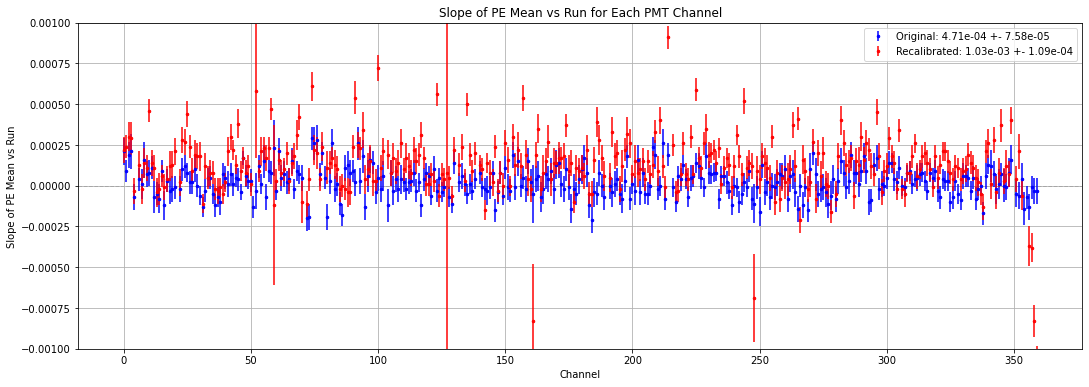

In [183]:
plt.figure(figsize=(18, 6))

# Add horizontal line at y=0 for reference (lowest layer)
plt.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5, zorder=1)

# Plot data points (top layer - will appear above fit lines)
plt.errorbar(df_sel['Channel'], df_sel['SlopeMean'], yerr=df_sel['SlopeMeanErr'], fmt='.', label=f'Original: {df_sel["SlopeMean"].mean():.2e} +- {df_sel["SlopeMeanErr"].mean():.2e}', color='blue', markersize=5, zorder=2)
plt.errorbar(df_sel['Channel'], df_sel['SlopeMeanRecal'], yerr=df_sel['SlopeMeanRecalErr'], fmt='.', label=f'Recalibrated: {df_sel["SlopeMeanRecal"].mean():.2e} +- {df_sel["SlopeMeanRecalErr"].mean():.2e}', color='red', markersize=5, zorder=2)

plt.xlabel('Channel')
plt.ylabel('Slope of PE Mean vs Run')
plt.title('Slope of PE Mean vs Run for Each PMT Channel')
plt.ylim(-1e-3, 1e-3)
plt.legend()
plt.grid()
plt.show()

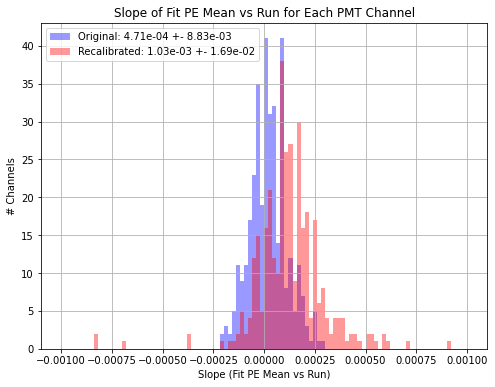

In [197]:
plt.figure(figsize=(8, 6))

# Add horizontal line at y=0 for reference (lowest layer)
plt.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5, zorder=1)

# Plot data points (top layer - will appear above fit lines)
plt.hist(df_sel['SlopeMean'], bins=100, range=(-1e-3, 1e-3), label=f'Original: {df_sel["SlopeMean"].mean():.2e} +- {df_sel["SlopeMean"].std():.2e}', color='blue', alpha=0.4)
plt.hist(df_sel['SlopeMeanRecal'], bins=100, range=(-1e-3, 1e-3), label=f'Recalibrated: {df_sel["SlopeMeanRecal"].mean():.2e} +- {df_sel["SlopeMeanRecal"].std():.2e}', color='red', alpha=0.4)

plt.ylabel('# Channels')
plt.xlabel('Slope (Fit PE Mean vs Run)')
plt.title('Slope of Fit PE Mean vs Run for Each PMT Channel')
#plt.ylim(-1e-3, 1e-3)
plt.legend()
plt.grid()
plt.show()

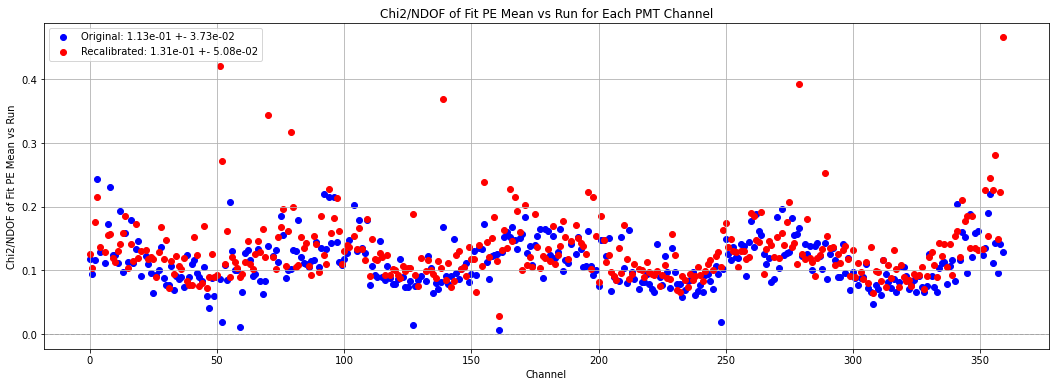

In [189]:
plt.figure(figsize=(18, 6))

# Add horizontal line at y=0 for reference (lowest layer)
plt.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5, zorder=1)

# Plot data points (top layer - will appear above fit lines)
plt.scatter(df_sel['Channel'], df_sel['fitM'], label=f'Original: {df_sel["fitM"].mean():.2e} +- {df_sel["fitM"].std():.2e}', color='blue')
plt.scatter(df_sel['Channel'], df_sel['fitM_recal'], label=f'Recalibrated: {df_sel["fitM_recal"].mean():.2e} +- {df_sel["fitM_recal"].std():.2e}', color='red')

plt.xlabel('Channel')
plt.ylabel('Chi2/NDOF of Fit PE Mean vs Run')
plt.title('Chi2/NDOF of Fit PE Mean vs Run for Each PMT Channel')
#plt.ylim(-1e-3, 1e-3)
plt.legend()
plt.grid()
plt.show()

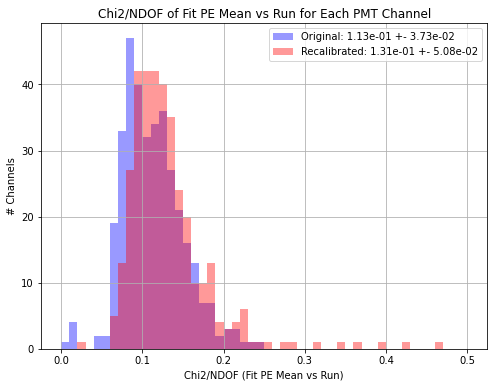

In [193]:
plt.figure(figsize=(8, 6))

# Add horizontal line at y=0 for reference (lowest layer)
plt.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5, zorder=1)

# Plot data points (top layer - will appear above fit lines)
plt.hist(df_sel['fitM'], bins=50, range=(0, 0.5), label=f'Original: {df_sel["fitM"].mean():.2e} +- {df_sel["fitM"].std():.2e}', color='blue', alpha=0.4)
plt.hist(df_sel['fitM_recal'], bins=50, range=(0, 0.5), label=f'Recalibrated: {df_sel["fitM_recal"].mean():.2e} +- {df_sel["fitM_recal"].std():.2e}', color='red', alpha=0.4)

plt.ylabel('# Channels')
plt.xlabel('Chi2/NDOF (Fit PE Mean vs Run)')
plt.title('Chi2/NDOF of Fit PE Mean vs Run for Each PMT Channel')
#plt.ylim(-1e-3, 1e-3)
plt.legend()
plt.grid()
plt.show()

In [9]:
df[df['Status'] == -1]

,Channel,SlopeMean,SlopeMeanErr,Chi2,NDF,Status,SlopeMeanRecal,SlopeMeanRecalErr,Chi2_recal,NDF_recal,Status_recal
5,5.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
21,21.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
71,71.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
103,103.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
131,131.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
190,190.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
215,215.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
350,350.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [10]:
bad_chans = df['Channel'][df['Status'] == -1].tolist()
bad_chans

[5.0, 21.0, 71.0, 103.0, 131.0, 190.0, 215.0, 350.0]

In [61]:
bad_channels = []
chan_entries = {}
runs = []
speFiles = getSPECalInfo()
speFiles = dict(sorted(speFiles.items()))
for ifile, (run, file) in enumerate(speFiles.items()):
    if not file.endswith('.csv'): continue
    runs.append(run)
    cal = pd.read_csv(file)
    bad_fits = cal['pmt'][cal['fitstatus'] != 0].to_list()
    bad_channels.extend(bad_fits)

print("bad channels", np.unique(bad_channels).tolist())

bad channels [5, 13, 21, 36, 52, 53, 59, 71, 76, 103, 104, 127, 131, 139, 161, 181, 190, 215, 225, 248, 270, 272, 316, 343, 350, 353]


In [55]:
chan_entries = {}
runs = []
speFiles = getSPECalInfo()
for ifile, (run, file) in enumerate(speFiles.items()):
    print(f"ifile {ifile}, run {run}, file {file}")
    if not file.endswith('.csv'): continue
    #if ifile > 1: break
    cal = pd.read_csv(file)
    runs.append(run)
    for chan in np.unique(bad_channels):
        entries = cal['nentries'][cal['pmt'] == chan].values[0]
        if chan in chan_entries:
            chan_entries[chan].append(entries)
        else:
            chan_entries[chan] = [entries]
        if chan == 127:
            print(f"Run {run}, Channel {chan}, Entries: {entries}")

print(len(chan_entries[5]), len(bad_channels), len(runs))


121 121


121 121


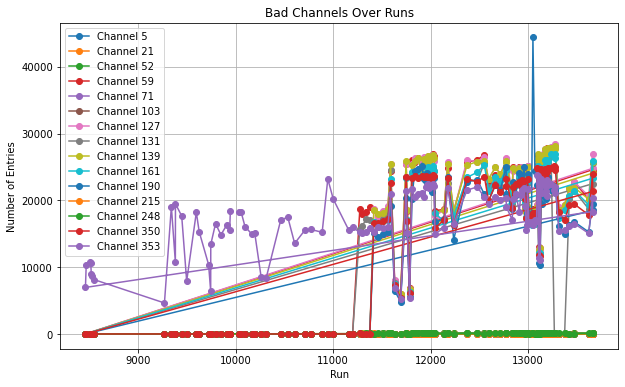

In [56]:
# Sort runs and chan_entries by run number
sorted_indices = np.argsort(runs)
runs = [runs[i] for i in sorted_indices]
for chan in chan_entries.keys():
    chan_entries[chan] = [chan_entries[chan][i] for i in sorted_indices]

plt.figure(figsize=(10, 6))
print(len(runs), len(chan_entries[5]))
entryCut = 3000

badInfo = pd.DataFrame(columns=['Channel', 'MaxEntries', 'NumBadFits', f'FirstRun>{entryCut}Entries', f'LastRun>{entryCut}Entries'])

for chan, entries in chan_entries.items():
    #if chan != 21: continue
    if bad_channels.count(chan) <= 20:
        continue
    plt.plot(runs, entries, marker='o', label=f'Channel {chan}', alpha=0.9)

    print(f"channel: {chan}, max(entries): {max(entries)}, bad_channels.count(chan): {bad_channels.count(chan)}")
    first_above = None
    last_above = None
    for j, (run_num, entry_count) in enumerate(zip(runs, entries)):
        if entry_count > entryCut:
            if first_above is None:
                first_above = run_num
            last_above = run_num
        elif first_above is not None and entry_count < entryCut:
            break

    if first_above is not None:
        print(f"Channel {chan}: First run > {entryCut}: {first_above}, Last run before < {entryCut}: {last_above}")

    badInfo = pd.concat([badInfo, pd.DataFrame([{'Channel': chan, 'MaxEntries': max(entries), 'NumBadFits': bad_channels.count(chan), f'FirstRun>{entryCut}Entries': first_above, f'LastRun>{entryCut}Entries': last_above}])], ignore_index=True)

plt.xlabel('Run')
plt.ylabel('Number of Entries')
plt.title('Bad Channels Over Runs')
plt.legend(ncol=2)
plt.grid()
plt.show()

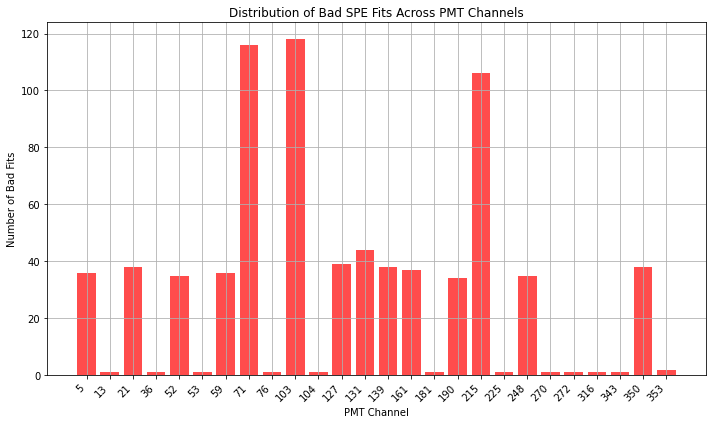

In [24]:
plt.figure(figsize=(10, 6))
# Count occurrences of each channel in bad_channels
channel_counts = {}
for channel in bad_channels:
    channel_counts[channel] = channel_counts.get(channel, 0) + 1

# Extract channels and their counts, sorted by channel number
# Only include channels that have at least one bad fit (count > 0)
channels = sorted(channel_counts.keys())
counts = [channel_counts[ch] for ch in channels]

plt.bar(range(len(channels)), counts, align='center', color='red', alpha=0.7)
plt.xticks(range(len(channels)), channels, rotation=45, ha='right')
plt.xlabel('PMT Channel')
plt.ylabel('Number of Bad Fits')
plt.title('Distribution of Bad SPE Fits Across PMT Channels')
plt.grid()
plt.tight_layout()
plt.show()


In [17]:
df_cal = pd.read_csv('/nashome/m/micarrig/icarus/pmt/v10_06_00_01p04/srcs/icaruscode/icaruscode/PMT/Calibration/calibrationdb/backgroundphotons_run10040_1688173120.csv')

df_cal[df_cal['fitstatus'] != 0]

,pmt,nentries,mu,emu,q,eq,sigma,esigma,amplitude,eamplitude,chi2,ndf,fitstatus
5,5,0,0.1,0.006643,0.575,0.001840,0.3,0.001820,1114.800049,89.134697,216.609665,152,-1
21,21,0,0.1,0.007093,0.575,0.001877,0.3,0.001795,1473.400024,71.166405,173.829987,159,-1
52,52,0,0.1,0.063181,0.575,0.063262,0.3,0.012996,1012.599976,250.508026,24.637697,35,-1
59,59,0,0.1,0.006159,0.575,0.001617,0.3,0.001627,712.400024,109.393745,283.035309,166,-1
71,71,0,0.1,0.007913,0.575,0.002125,0.3,0.002125,1103.199951,87.295204,133.430145,145,-1
103,103,0,0.1,0.003863,0.575,0.001533,0.3,0.001500,1196.400024,341.269165,218.601044,138,-1
127,127,0,0.1,0.002870,0.575,0.001281,0.3,0.001211,876.400024,669.221680,202.401825,125,-1
131,131,0,0.1,0.003750,0.575,0.001462,0.3,0.001409,872.400024,309.336853,245.732483,137,-1
161,161,0,0.1,0.005910,0.575,0.001803,0.3,0.001731,971.799988,142.347870,240.407059,159,-1
190,190,0,0.1,0.003427,0.575,0.001406,0.3,0.001373,874.200012,436.434784,302.986206,137,-1


In [22]:
df_cal[df_cal['fitstatus'] == 0]

,pmt,nentries,mu,emu,q,eq,sigma,esigma,amplitude,eamplitude,chi2,ndf,fitstatus
0,0,12010,0.028938,0.003470,0.440011,0.002093,0.148456,0.001732,4902.872070,584.083252,122.631615,113,0
1,1,12210,0.041772,0.004369,0.448437,0.002100,0.161318,0.001886,3276.293213,338.511871,143.508972,121,0
2,2,15470,0.091759,0.006029,0.434608,0.001637,0.153686,0.001603,1774.501831,112.527390,306.807922,149,0
3,3,15461,0.027560,0.003276,0.432672,0.001581,0.156486,0.001446,5902.102051,695.381958,178.908676,135,0
4,4,15181,0.109206,0.006643,0.438746,0.001840,0.162589,0.001820,1526.726807,89.134697,216.609665,152,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,355,14963,0.018736,0.003049,0.444460,0.001561,0.152689,0.001383,8392.268555,1355.393433,157.194000,120,0
356,356,21362,0.038672,0.003120,0.441596,0.001268,0.153463,0.001172,5693.203125,452.421234,294.935120,134,0
357,357,17560,0.025483,0.003413,0.451091,0.001568,0.167345,0.001466,7236.893555,959.601196,168.384018,128,0
358,358,15407,0.017056,0.003125,0.464205,0.001628,0.166412,0.001447,9382.816406,1707.371338,165.117813,129,0


In [14]:
#look at a specific bad channel
fin = r.TFile.Open("/exp/icarus/data/users/micarrig/histograms/pulseDistributionHist_run10040.root", "READ")
fin.cd("bkgcalibration")
fin.ls()

TFile**		/exp/icarus/data/users/micarrig/histograms/pulseDistributionHist_run10040.root	
 TFile*		/exp/icarus/data/users/micarrig/histograms/pulseDistributionHist_run10040.root	
  TDirectoryFile*		bkgcalibration	bkgcalibration (PMTBackgroundphotonsCalibration) folder
   KEY: TTree	ophits;1	ophits tree
   KEY: TH1D	hintegral0;1	PMT: 0
   KEY: TH1D	hamplitude0;1	PMT: 0
   KEY: TH1D	hintegral1;1	PMT: 1
   KEY: TH1D	hamplitude1;1	PMT: 1
   KEY: TH1D	hintegral2;1	PMT: 2
   KEY: TH1D	hamplitude2;1	PMT: 2
   KEY: TH1D	hintegral3;1	PMT: 3
   KEY: TH1D	hamplitude3;1	PMT: 3
   KEY: TH1D	hintegral4;1	PMT: 4
   KEY: TH1D	hamplitude4;1	PMT: 4
   KEY: TH1D	hintegral5;1	PMT: 5
   KEY: TH1D	hamplitude5;1	PMT: 5
   KEY: TH1D	hintegral6;1	PMT: 6
   KEY: TH1D	hamplitude6;1	PMT: 6
   KEY: TH1D	hintegral7;1	PMT: 7
   KEY: TH1D	hamplitude7;1	PMT: 7
   KEY: TH1D	hintegral8;1	PMT: 8
   KEY: TH1D	hamplitude8;1	PMT: 8
   KEY: TH1D	hintegral9;1	PMT: 9
   KEY: TH1D	hamplitude9;1	PMT: 9
   KEY: TH1D	hintegral10;1	

In [15]:
%jsroot on

In [19]:
r.gStyle.SetOptStat(0)
c1 = r.TCanvas("c1", "Channel 50 Integral5", 800, 600)
l1 = r.TLegend(0.6, 0.7, 0.85, 0.85)
for i, ich in enumerate(df_cal['pmt'][df_cal['fitstatus'] != 0].tolist()):
    h = fin.Get(f"bkgcalibration/hintegral{ich}")
    h.SetLineColor(i+1)
    l1.AddEntry(h, f"Channel {ich}", "l")
    if i == 0:
        h.SetTitle("Bad PMT Fits Run 10040")
        h.GetYaxis().SetRangeUser(0, 3200) 
        h.Draw()
    else: h.Draw("same")


l1.Draw()
c1.Draw()
c1.SetLogy()

Error in <THistPainter::PaintInit>: Cannot set Y axis to log scale
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


In [20]:
r.gStyle.SetOptStat(0)
c1 = r.TCanvas("c1", "Channel 50 Integral5", 800, 600)
l1 = r.TLegend(0.6, 0.7, 0.85, 0.85)
for i, ich in enumerate(df_cal['pmt'][df_cal['fitstatus'] == 0].tolist()):
    if i > 2: break
    h = fin.Get(f"bkgcalibration/hintegral{ich}")
    h.SetLineColor(i+1)
    l1.AddEntry(h, f"Channel {ich}", "l")
    if i == 0:
        h.SetTitle("Good PMT Fits Run 10040")
        h.GetYaxis().SetRangeUser(0, 5000) 
        h.Draw()
    else: h.Draw("same")


l1.Draw()
c1.Draw()
c1.SetLogy()

Error in <THistPainter::PaintInit>: Cannot set Y axis to log scale
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


In [2]:
#https://docs.google.com/spreadsheets/d/1Kra6eIflTKS_sMghBqgpy1h86Z8WKkibZLrLnDAdWaQ/edit?gid=0#gid=0
bad_runs = [9304, 9305, 9306, 9320, 9321, 9322, 9323, 9324, 9325, 9326, 9348, 9349, 9350, 9351, 9352, 9381, 9382, 9395, 9396, 9397, 9398, 9399, 9400, 9401, 9402, 9403, 9404, 9405, 9406, 9407, 9408, 9410, 9411, 9413, 9414, 9416, 9433, 9434, 9440, 9446, 9447, 9449, 9451, 9452, 9453, 9454, 9455, 9456, 9459, 9461, 9462, 9463, 9465, 9466, 9467, 9468, 9469, 9470, 9471, 9476, 9479, 9480, 9483, 9484, 9485, 9486, 9487, 9488, 9489, 9490, 9491, 9492, 9493, 9494, 9496, 9497, 9498, 9500, 9501, 9502, 9503, 9505, 9506, 9507, 9508, 9509, 9510, 9511, 9512, 9519, 9520, 9521, 9522, 9523, 9524, 9525, 9526, 9527, 9528, 9529, 9530, 9535, 9536, 9537, 9538, 9539, 9540, 9541, 9542, 9543, 9544, 9545, 9546, 9547, 9548, 9549, 9550, 9551, 9552, 9553, 9554, 9555, 9556, 9557, 9561, 9567, 9572, 9573, 9574, 9575, 9576, 9577, 9578, 9579, 9581, 9591, 9592, 9596, 9600, 9601, 9603, 9604, 9605, 9606, 9607, 9608, 9609, 9611, 9612, 9613, 9614, 9615, 9616, 9617, 9618, 9619, 9620, 9621, 9622, 9623, 9628, 9629, 9630, 9632, 9633, 9635, 9636, 9637, 9638, 9639, 9640, 9641, 9643, 9644, 9645, 9650, 9651, 9652, 9653, 9654, 9655, 9656, 9657, 9659, 9660, 9661, 9662, 9663, 9664, 9665, 9666, 9667, 9668, 9669, 9670, 9671, 9676, 9677, 9678, 9679, 9680, 9681, 9682, 9683, 9684, 9685, 9686, 9701, 9702, 9706, 9707, 9708, 9709, 9710, 9711, 9712, 9713, 9718, 9719, 9736, 9737, 9738, 9739, 9740, 9741, 9742, 9759, 9767, 9768, 9769, 9770, 9771, 9772, 9773, 9774, 9775, 9776, 9777, 9778, 9787, 9789, 9790, 9798, 9799, 9800, 9801, 9802, 9803, 9804, 9805, 9806, 9808, 9809, 9810, 9811, 9812, 9813, 9815, 9816, 9817, 9818, 9819, 9820, 9821, 9822, 9823, 9824, 9825, 9826, 9827, 9828, 9829, 9830, 9831, 9832, 9833, 9845, 9846, 9856, 9857, 9864, 9865, 9866, 9872, 9873, 9874, 9875, 9876, 9877, 9878, 9879, 9880, 9881, 9882, 9883, 9884, 9885, 9886, 9887, 9888, 9889, 9890, 9891, 9895, 9898, 9899, 9900, 9901, 9902, 9903, 9904, 9905, 9906, 9907, 9908, 9909, 9910, 9912, 9927, 9928, 9930, 9936, 9937, 9938, 9939, 9952, 9957, 9958, 9963, 9964, 9965, 9966, 9967, 9969, 9976, 9990, 9992, 9993, 9994, 9995, 9996, 9997, 9998, 9999, 10000, 10001, 10002, 10003, 10004, 10005, 10006, 10007, 10008, 10011, 10012, 10013, 10014, 10016, 10017, 10018, 10019, 10020, 10021, 10022, 10023, 10024, 10025, 10026, 10027, 10028, 10029, 10031, 10032, 10033, 10034, 10035, 10036, 10037, 10038, 10039, 10041, 10042, 10043, 10044, 10045, 10046, 10047, 10049, 10050, 10051, 10052, 10053, 10069, 10070, 10071, 10072, 10073, 10074, 10075, 10076, 10077, 10078, 10079, 10080, 10081, 10082, 10083]
speFiles = getSPECalInfo()
removed_spe_runs = sorted(set(speFiles.keys()) & set(bad_runs))
speFiles = {k: v for k, v in speFiles.items() if k not in bad_runs}

gains, gainsErr = calculateNewGains(speFiles) #dict of run/channel sPE areas

In [9]:
chan = 25
c1 = r.TCanvas("c1", f"Channel {chan} PE Mean vs Run", 1200, 600)
c1.SetGrid()
# Add some margin on the right for the second axis
c1.SetRightMargin(0.12)

setyMin = 0
setyMax = 2

g_meanPMT = r.TGraphErrors()
g_recalMeanPMT = r.TGraphErrors()
g_meanPMTFit = r.TGraphErrors()

speRuns = [r.TLine(run, setyMin, run, setyMax) for run in speFiles.keys() if run < 10000]

ptOrig, ptRecal, ptFit = 0, 0, 0
for i, info in enumerate(runInfos):
    run = info.run_number
    if run in bad_runs: continue
    if info.meanPMT[chan] > 0 and info.meanPMTErr[chan] > 0: 
        #if info.meanPMTErr[chan] > 0.1: continue
        g_meanPMT.SetPoint(ptOrig, run, info.meanPMT[chan])
        g_meanPMT.SetPointError(ptOrig, 0, info.meanPMTErr[chan])
        ptOrig += 1
    if info.recalMeanPMT[chan] > 0 and info.recalMeanPMTErr[chan] > 0:
        #if info.recalMeanPMTErr[chan] > 0.1: continue
        g_recalMeanPMT.SetPoint(ptRecal, run, info.recalMeanPMT[chan])
        g_recalMeanPMT.SetPointError(ptRecal, 0, info.recalMeanPMTErr[chan])
        ptRecal += 1
    if info.fitMeanPMT[chan] > 0 and info.fitMeanPMTErr[chan] > 0: 
        #if info.fitMeanPMTErr[chan] > 0.1: continue
        g_meanPMTFit.SetPoint(ptFit, run, info.fitMeanPMT[chan])
        g_meanPMTFit.SetPointError(ptFit, 0, info.fitMeanPMTErr[chan])
        ptFit += 1

g_meanPMT.SetMarkerColor(r.kBlue+2)
g_meanPMT.SetTitle(f"Channel {chan} PE Mean vs Run;Run Number;PE Mean")
g_meanPMT.SetMarkerStyle(20)
g_recalMeanPMT.SetMarkerStyle(21)
g_meanPMT.SetMarkerSize(0.5)
g_recalMeanPMT.SetMarkerSize(0.7)
g_recalMeanPMT.SetMarkerColor(r.kRed+2)
g_meanPMT.GetYaxis().SetRangeUser(setyMin, setyMax)
g_meanPMTFit.SetMarkerColor(r.kOrange+2)
g_meanPMTFit.SetMarkerStyle(23)
g_meanPMTFit.SetMarkerSize(1)

# Draw the main graphs
g_meanPMT.Draw("AP")
g_recalMeanPMT.Draw("P same")
g_meanPMTFit.Draw("P same")

# Ensure canvas is updated to get correct user ranges
c1.Update()

# Get the y-axis range of the current pad (robust)
ymin = r.gPad.GetUymin()
ymax = r.gPad.GetUymax()

maxFit = g_recalMeanPMT.GetXaxis().GetXmax()
minFit = g_recalMeanPMT.GetXaxis().GetXmin()
# Fit the graphs
f_mean = r.TF1("f_mean", "[0]+x*[1]", g_meanPMT.GetXaxis().GetXmin(), g_meanPMT.GetXaxis().GetXmax())
f_meanRecal = r.TF1("f_meanRecal", "[0]+x*[1]", g_recalMeanPMT.GetXaxis().GetXmin(), g_recalMeanPMT.GetXaxis().GetXmax())
f_meanFit = r.TF1("f_meanFit", "[0]+x*[1]", g_meanPMTFit.GetXaxis().GetXmin(), g_meanPMTFit.GetXaxis().GetXmax())

status = g_meanPMT.Fit(f_mean, "QEMNRCF", "", minFit, maxFit)
status_recal = g_recalMeanPMT.Fit(f_meanRecal, "QEMNRCF", "", minFit, maxFit)
status_fit = g_meanPMTFit.Fit(f_meanFit, "QEMNRCF", "", minFit, maxFit)

f_mean.SetLineColor(r.kBlue)
f_meanRecal.SetLineColor(r.kRed)
f_meanFit.SetLineColor(r.kOrange+2)
f_mean.SetLineWidth(2)
f_meanRecal.SetLineWidth(2)
f_meanFit.SetLineWidth(2)
f_meanFit.Draw("same")
f_mean.Draw("same")
f_meanRecal.Draw("same")

for l in speRuns:
    l.SetLineColor(r.kMagenta+2)
    l.SetLineStyle(4)
    l.Draw("same")

# Legend
l1 = r.TLegend(0.12, 0.1, 0.45, 0.3)
l1.AddEntry(g_meanPMT, f"Original: slope={f_mean.GetParameter(1):.2E} #pm {f_mean.GetParError(1):.2E}", "pl")
l1.AddEntry(g_recalMeanPMT, f"Recal: slope={f_meanRecal.GetParameter(1):.2E} #pm {f_meanRecal.GetParError(1):.2E}", "pl")
l1.AddEntry(g_meanPMTFit, f"Fit: slope={f_meanFit.GetParameter(1):.2E} #pm {f_meanFit.GetParError(1):.2E}", "pl")


# Now overlay the sPE area graph if available
if gains is not None and gainsErr is not None:
    g_sPE = r.TGraphErrors()
    for irun, (run, sPEs) in enumerate(gains.items()):
        if run > 10200: continue
        g_sPE.SetPoint(irun, run, sPEs[chan])
        g_sPE.SetPointError(irun, 0, gainsErr[run][chan])

    # make fit for the sPE graph
    f_sPE = r.TF1("f_sPE", "[0]+x*[1]", g_sPE.GetXaxis().GetXmin(), g_sPE.GetXaxis().GetXmax())
    status_sPE = g_sPE.Fit(f_sPE, "QEMNRCF", "", 9200, 10200)
    f_sPE.SetLineColor(r.kGreen+2)
    f_sPE.SetLineWidth(2)

    f_sPE1 = f_sPE.GetParameter(1)
    f_sPE1Err = f_sPE.GetParError(1)    

    # Get the range of sPE values for scaling
    sPE_vals = [g_sPE.GetPointY(i) for i in range(g_sPE.GetN()) if (g_sPE.GetPointY(i) > 1e-5 and g_sPE.GetPointX(i) < 10010)]

    if len(sPE_vals) > 0:
        sPE_min = min(sPE_vals) * 0.9
        sPE_max = max(sPE_vals) * 1.1
    else:
        sPE_min, sPE_max = 0.0, 1.0
    denom = (sPE_max - sPE_min) if (sPE_max - sPE_min) != 0 else 1.0

    # Scale g_sPE to fit in the same y-range as the main plot
    g_sPE_scaled = r.TGraphErrors()
    for i in range(g_sPE.GetN()):
        x = g_sPE.GetPointX(i)
        y_orig = g_sPE.GetPointY(i)
        # Scale from [sPE_min, sPE_max] to [ymin, ymax]
        y_scaled = ymin + (y_orig - sPE_min) * (ymax - ymin) / denom
        g_sPE_scaled.SetPoint(i, x, y_scaled)
        #print("Scaled sPE point:", x, y_orig, y_scaled)
        g_sPE_scaled.SetPointError(i, 0, g_sPE.GetErrorY(i) * (ymax - ymin) / denom)

    # Style the sPE graph
    g_sPE_scaled.SetMarkerColor(r.kGreen+2)
    g_sPE_scaled.SetLineColor(r.kGreen+2)
    g_sPE_scaled.SetMarkerStyle(22)
    g_sPE_scaled.SetMarkerSize(1)
    g_sPE_scaled.Draw("P same")

    # Draw a scaled version of the fitted sPE line without mutating the fit
    x_min = g_sPE.GetXaxis().GetXmin()
    x_max = g_sPE.GetXaxis().GetXmax()
    f_sPE_scaled = r.TF1("f_sPE_scaled", "[0]+x*[1]", x_min, x_max)
    a0 = f_sPE.GetParameter(0)
    a1 = f_sPE.GetParameter(1)
    scale = (ymax - ymin) / denom
    f_sPE_scaled.SetParameter(0, ymin + (a0 - sPE_min) * scale)
    f_sPE_scaled.SetParameter(1, a1 * scale)
    f_sPE_scaled.SetLineColor(r.kGreen+2)
    f_sPE_scaled.SetLineStyle(2)
    f_sPE_scaled.Draw("same")

    # Create a second y-axis on the right for sPE
    c1.Update()  # Important: update canvas to get proper coordinates
    axis = r.TGaxis(
        r.gPad.GetUxmax(), r.gPad.GetUymin(),  # x1, y1 (bottom right)
        r.gPad.GetUxmax(), r.gPad.GetUymax(),  # x2, y2 (top right)
        sPE_min, sPE_max,                      # wmin, wmax (actual sPE range)
        510, "+L"
    )
    axis.SetLineColor(r.kGreen+2)
    axis.SetLabelColor(r.kGreen+2)
    axis.SetTextColor(r.kGreen+2)
    axis.SetTitleColor(r.kGreen+2)
    axis.SetTitle("SPE Area (ADC #times tick)")
    axis.SetTitleOffset(1.2)
    axis.Draw()

    l1.AddEntry(g_sPE_scaled, f"SPE Area: slope={f_sPE1:.2E} #pm {f_sPE1Err:.2E}", "pl")

l1.Draw()
c1.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


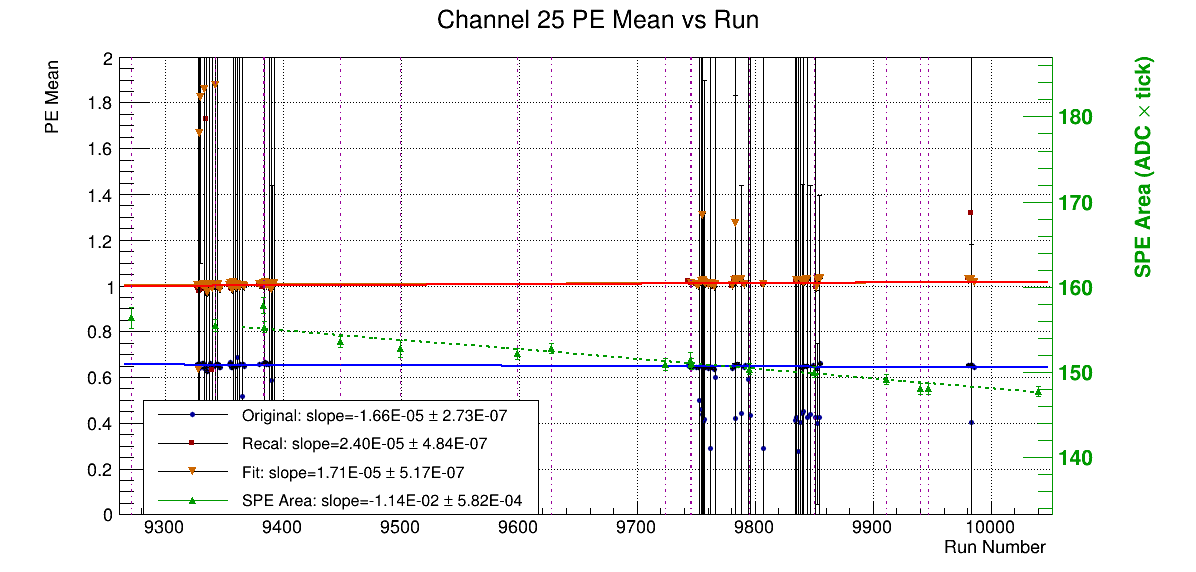

In [10]:
c1.Draw()

### Make fits to sPE area for each channel

In [2]:
# https://docs.google.com/spreadsheets/d/1Kra6eIflTKS_sMghBqgpy1h86Z8WKkibZLrLnDAdWaQ/edit?gid=0#gid=0
bad_runs = [9304, 9305, 9306, 9320, 9321, 9322, 9323, 9324, 9325, 9326, 9348, 9349, 9350, 9351, 9352, 9381, 9382, 9395, 9396, 9397, 9398, 9399, 9400, 9401, 9402, 9403, 9404, 9405, 9406, 9407, 9408, 9410, 9411, 9413, 9414, 9416, 9433, 9434, 9440, 9446, 9447, 9449, 9451, 9452, 9453, 9454, 9455, 9456, 9459, 9461, 9462, 9463, 9465, 9466, 9467, 9468, 9469, 9470, 9471, 9476, 9479, 9480, 9483, 9484, 9485, 9486, 9487, 9488, 9489, 9490, 9491, 9492, 9493, 9494, 9496, 9497, 9498, 9500, 9501, 9502, 9503, 9505, 9506, 9507, 9508, 9509, 9510, 9511, 9512, 9519, 9520, 9521, 9522, 9523, 9524, 9525, 9526, 9527, 9528, 9529, 9530, 9535, 9536, 9537, 9538, 9539, 9540, 9541, 9542, 9543, 9544, 9545, 9546, 9547, 9548, 9549, 9550, 9551, 9552, 9553, 9554, 9555, 9556, 9557, 9561, 9567, 9572, 9573, 9574, 9575, 9576, 9577, 9578, 9579, 9581, 9591, 9592, 9596, 9600, 9601, 9603, 9604, 9605, 9606, 9607, 9608, 9609, 9611, 9612, 9613, 9614, 9615, 9616, 9617, 9618, 9619, 9620, 9621, 9622, 9623, 9628, 9629, 9630, 9632, 9633, 9635, 9636, 9637, 9638, 9639, 9640, 9641, 9643, 9644, 9645, 9650, 9651, 9652, 9653, 9654, 9655, 9656, 9657, 9659, 9660, 9661, 9662, 9663, 9664, 9665, 9666, 9667, 9668, 9669, 9670, 9671, 9676, 9677, 9678, 9679, 9680, 9681, 9682, 9683, 9684, 9685, 9686, 9701, 9702, 9706, 9707, 9708, 9709, 9710, 9711, 9712, 9713, 9718, 9719, 9736, 9737, 9738, 9739, 9740, 9741, 9742, 9759, 9767, 9768, 9769, 9770, 9771, 9772, 9773, 9774, 9775, 9776, 9777, 9778, 9787, 9789, 9790, 9798, 9799, 9800, 9801, 9802, 9803, 9804, 9805, 9806, 9808, 9809, 9810, 9811, 9812, 9813, 9815, 9816, 9817, 9818, 9819, 9820, 9821, 9822, 9823, 9824, 9825, 9826, 9827, 9828, 9829, 9830, 9831, 9832, 9833, 9845, 9846, 9856, 9857, 9864, 9865, 9866, 9872, 9873, 9874, 9875, 9876, 9877, 9878, 9879, 9880, 9881, 9882, 9883, 9884, 9885, 9886, 9887, 9888, 9889, 9890, 9891, 9895, 9898, 9899, 9900, 9901, 9902, 9903, 9904, 9905, 9906, 9907, 9908, 9909, 9910, 9912, 9927, 9928, 9930, 9936, 9937, 9938, 9939, 9952, 9957, 9958, 9963, 9964, 9965, 9966, 9967, 9969, 9976, 9990, 9992, 9993, 9994, 9995, 9996, 9997, 9998, 9999, 10000, 10001, 10002, 10003, 10004, 10005, 10006, 10007, 10008, 10011, 10012, 10013, 10014, 10016, 10017, 10018, 10019, 10020, 10021, 10022, 10023, 10024, 10025, 10026, 10027, 10028, 10029, 10031, 10032, 10033, 10034, 10035, 10036, 10037, 10038, 10039, 10041, 10042, 10043, 10044, 10045, 10046, 10047, 10049, 10050, 10051, 10052, 10053, 10069, 10070, 10071, 10072, 10073, 10074, 10075, 10076, 10077, 10078, 10079, 10080, 10081, 10082, 10083]
speFiles = getSPECalInfo()
removed_spe_runs = sorted(set(speFiles.keys()) & set(bad_runs))
speFiles = {k: v for k, v in speFiles.items() if k not in bad_runs}

gains, gainsErr, fits = calculateNewGains(speFiles) #dict of run/channel sPE areas

In [5]:
c1 = r.TCanvas("c1", "C1", 800, 600)
df = pd.DataFrame(columns=['Channel', 'm', 'b', 'mErr', 'bErr', 'Chi2', 'NDF'])

#known bad channels
bad_chans = [350, 248, 215, 190, 161, 139, 127, 103, 131, 59, 52, 21, 5, 71]

fout = r.TFile.Open("/nashome/m/micarrig/icarus/pmt/v10_06_00_01p04/speAreaFits.root", 'RECREATE')
for chan in range(360):
    if chan % 50 == 0:
        print(f"Processing channel {chan}")
    c1.Clear()
    if chan in bad_chans:
        continue

    g_sPE = r.TGraphErrors()
    for irun, (run, sPEs) in enumerate(gains.items()):
        if run > 10200: continue
        if sPEs[chan] < 20: continue
        if fits[run][chan] > 20: continue
        #if chan > 180 and run == 10197: continue
        g_sPE.SetPoint(irun, run, sPEs[chan])
        g_sPE.SetPointError(irun, 0, gainsErr[run][chan])

    # make fit for the sPE graph
    f_sPE = r.TF1("f_sPE", "[0]+x*[1]", g_sPE.GetXaxis().GetXmin(), g_sPE.GetXaxis().GetXmax())
    status_sPE = g_sPE.Fit(f_sPE, "QEMNR", "", 8400, 10200)
    f_sPE.SetLineColor(r.kGreen+2)
    f_sPE.SetLineWidth(2)

    f_sPE1 = f_sPE.GetParameter(1)
    f_sPE1Err = f_sPE.GetParError(1) 
    print(status_sPE)

    # Append results for this channel at end of df
    df.loc[len(df)] = [chan, f_sPE1, f_sPE.GetParameter(0), f_sPE1Err, f_sPE.GetParError(0), f_sPE.GetChisquare(), f_sPE.GetNDF()]

    g_sPE.SetTitle(f"Channel {chan} SPE Area vs Run;Run Number;SPE Area (ADC #times tick)")
    g_sPE.GetXaxis().SetRangeUser(8400., 10200.)
    t = r.TLatex()
    t.SetTextSize(4)

    g_sPE.Draw("AP")
    f_sPE.Draw("same")
    # Place annotation in NDC coordinates (independent of axis ranges)
    r.gPad.Update()
    t.SetTextSize(0.035)
    t.SetNDC(True)
    t.DrawLatex(0.15, 0.85, f"SPE Area Fit: slope={f_sPE1:.2E} #pm {f_sPE1Err:.2E}")

    fout.cd()
    c1.Write(f"chan{chan}")
    #c1.Draw()
fout.Close()

Processing channel 0
<nullptr TFitResult>
<nullptr TFitResult>
<nullptr TFitResult>
<nullptr TFitResult>
<nullptr TFitResult>
<nullptr TFitResult>
<nullptr TFitResult>
<nullptr TFitResult>
<nullptr TFitResult>
<nullptr TFitResult>
<nullptr TFitResult>
<nullptr TFitResult>
<nullptr TFitResult>
<nullptr TFitResult>
<nullptr TFitResult>
<nullptr TFitResult>
<nullptr TFitResult>
<nullptr TFitResult>
<nullptr TFitResult>
<nullptr TFitResult>
<nullptr TFitResult>
<nullptr TFitResult>
<nullptr TFitResult>
<nullptr TFitResult>
<nullptr TFitResult>
<nullptr TFitResult>
<nullptr TFitResult>
<nullptr TFitResult>
<nullptr TFitResult>
<nullptr TFitResult>
<nullptr TFitResult>
<nullptr TFitResult>
<nullptr TFitResult>
<nullptr TFitResult>
<nullptr TFitResult>
<nullptr TFitResult>
<nullptr TFitResult>
<nullptr TFitResult>
<nullptr TFitResult>
<nullptr TFitResult>
<nullptr TFitResult>
<nullptr TFitResult>
<nullptr TFitResult>
<nullptr TFitResult>
<nullptr TFitResult>
<nullptr TFitResult>
<nullptr TFit

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


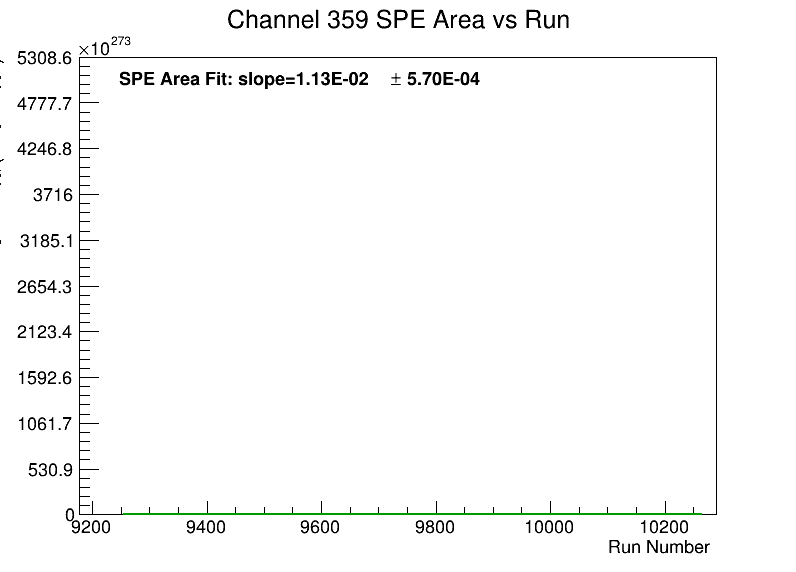

In [173]:
c1.Draw()

In [6]:
df[df['b'] < 0]

,Channel,m,b,mErr,bErr,Chi2,NDF
87,92.0,0.040507,-255.148730,0.000191,1.822344,13947.730074,26.0
279,292.0,0.031481,-144.081405,0.000113,1.133882,80214.891936,26.0
292,305.0,0.030800,-135.664615,0.000141,1.432849,90113.888655,26.0


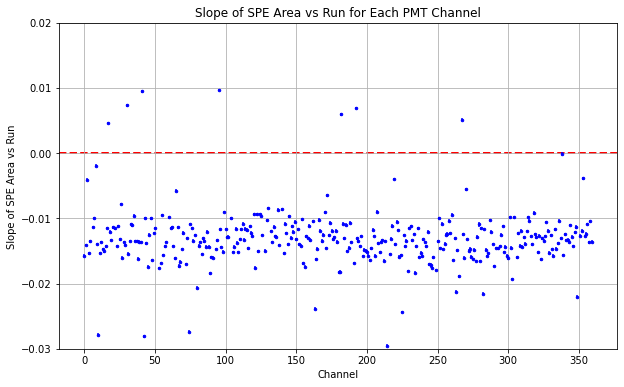

In [7]:
plt.figure(figsize=(10, 6))

plt.errorbar(df['Channel'], df['m'], yerr=df['mErr'], fmt='.', color='blue', markersize=5)
plt.axhline(y=0, color='red', linestyle='--', linewidth=2, alpha=1, zorder=1)
plt.xlabel('Channel')
plt.ylabel('Slope of SPE Area vs Run')
plt.title('Slope of SPE Area vs Run for Each PMT Channel')
plt.ylim(-0.03, 0.02)
plt.grid()
plt.show()

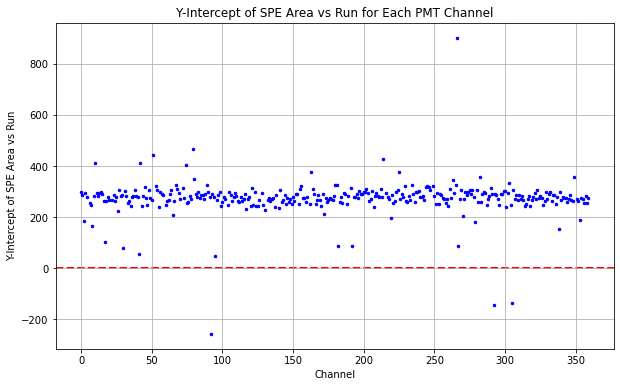

In [8]:
plt.figure(figsize=(10, 6))

plt.errorbar(df['Channel'], df['b'], yerr=df['bErr'], fmt='.', color='blue', markersize=5)
plt.axhline(y=0, color='red', linestyle='--', linewidth=2, alpha=1, zorder=1)
plt.xlabel('Channel')
plt.ylabel('Y-Intercept of SPE Area vs Run')
plt.title('Y-Intercept of SPE Area vs Run for Each PMT Channel')
#plt.ylim(-0.03, 0.02)
plt.grid()
plt.show()

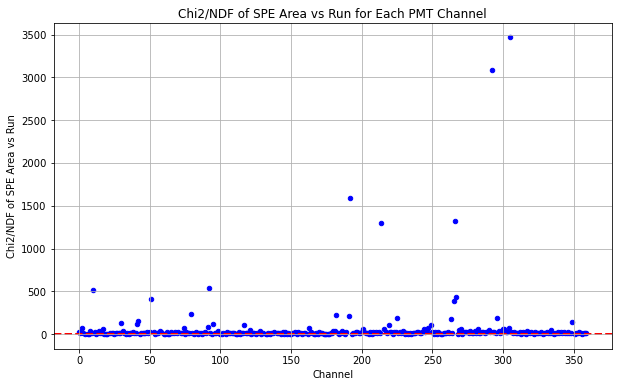

In [9]:
plt.figure(figsize=(10, 6))

plt.scatter(df['Channel'], df['Chi2']/df['NDF'], color='blue', s=20)
plt.axhline(y=0, color='red', linestyle='--', linewidth=2, alpha=1, zorder=1)
plt.xlabel('Channel')
plt.ylabel('Chi2/NDF of SPE Area vs Run')
plt.title('Chi2/NDF of SPE Area vs Run for Each PMT Channel')
plt.grid()
plt.show()

In [10]:
pd.set_option('display.max_rows', None)

df["FitQuality"] = df['Chi2']/df['NDF']
df[df['FitQuality'] > 100]

,Channel,m,b,mErr,bErr,Chi2,NDF,FitQuality
9,10.0,-0.027831,411.069754,0.000204,1.953084,13244.994257,26.0,509.422856
28,30.0,0.007302,78.564021,0.000200,1.893616,3460.059592,26.0,133.079215
39,41.0,0.009456,54.940663,0.000167,1.584258,2927.621874,26.0,112.600841
40,42.0,-0.028076,413.588002,0.000197,1.894896,3959.303519,26.0,152.280905
49,51.0,-0.036869,443.699375,0.000159,1.506520,10531.953946,26.0,405.075152
74,79.0,-0.037593,466.371811,0.000158,1.509940,5857.049722,25.0,234.281989
87,92.0,0.040507,-255.148730,0.000191,1.822344,13947.730074,26.0,536.451157
90,95.0,0.009705,47.627292,0.000161,1.530471,3127.055507,26.0,120.271366
111,117.0,-0.011219,230.085977,0.000210,2.027870,2894.982598,26.0,111.345485
172,182.0,0.005942,88.984224,0.000201,1.920622,5735.699716,26.0,220.603835


In [29]:
c1 = r.TCanvas("c1", "c1", 800, 600)
c1.Clear()
chan = 292
g_sPE = r.TGraphErrors()
for irun, (run, sPEs) in enumerate(gains.items()):
    if run > 10200: continue
    if sPEs[chan] < 20: continue
    if fits[run][chan] > 20: continue
    print(run, sPEs[chan], gainsErr[run][chan])
    g_sPE.SetPoint(irun, run, sPEs[chan])
    g_sPE.SetPointError(irun, 0, gainsErr[run][chan])

# make fit for the sPE graph
f_sPE = r.TF1("f_sPE", "[0]+x*[1]", g_sPE.GetXaxis().GetXmin(), g_sPE.GetXaxis().GetXmax())
status_sPE = g_sPE.Fit(f_sPE, "QEMNR", "", 8400, 10200)
f_sPE.SetLineColor(r.kGreen+2)
f_sPE.SetLineWidth(2)

f_sPE1 = f_sPE.GetParameter(1)
f_sPE1Err = f_sPE.GetParError(1) 

g_sPE.SetTitle(f"Channel {chan} SPE Area vs Run;Run Number;SPE Area (ADC #times tick)")
g_sPE.GetXaxis().SetRangeUser(8400., 10200.)
t = r.TLatex()

g_sPE.Draw("AP")
f_sPE.Draw("same")
# Place annotation in NDC coordinates (independent of axis ranges)
r.gPad.Update()
t.SetTextSize(0.035)
t.SetNDC(True)
t.DrawLatex(0.15, 0.35, f"SPE Area Fit: slope={f_sPE1:.2E} #pm {f_sPE1Err:.2E}")
t2 = r.TLatex()
t2.SetTextSize(0.035)
t2.SetNDC(True)
t2.DrawLatex(0.15, 0.30, f"Fit Quality: Chi2/NDF={df['FitQuality'][df['Channel'] == chan].values[0]:.2f}")

print(f_sPE.GetParameter(0), f_sPE.GetParError(0))


10040 135.12114959016392 0.3919647540983607
10058 134.4997180327869 0.39032336065573775
10097 131.58329016393444 0.41527254098360655
10165 127.36261106557377 0.44645901639344276
10197 180.55327868852459 0.044317622950819674
8461 143.77490409836065 0.7209
8469 145.38970696721313 0.5298418032786886
8505 140.08242540983608 0.5094885245901639
8515 139.19607295081968 0.5216348360655738
8521 135.5859922131148 0.5584020491803279
8530 133.34614672131147 0.5738311475409836
8552 134.55913647540984 0.5206500000000001
9271 147.17784098360656 0.9408467213114755
9342 148.16792950819672 0.4366106557377049
9383 145.18157827868853 0.5482254098360656
9384 146.55575286885247 0.4395651639344263
9448 146.29247336065575 0.4014848360655738
9499 144.12189467213116 0.6975922131147542
9598 146.07482459016393 0.44317622950819674
9627 150.2902512295082 0.4674688524590164
9724 148.82251721311476 0.5068622950819672
9745 145.47177663934428 0.6371889344262295
9746 145.24362295081968 0.43628237704918044
9795 144.53421

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


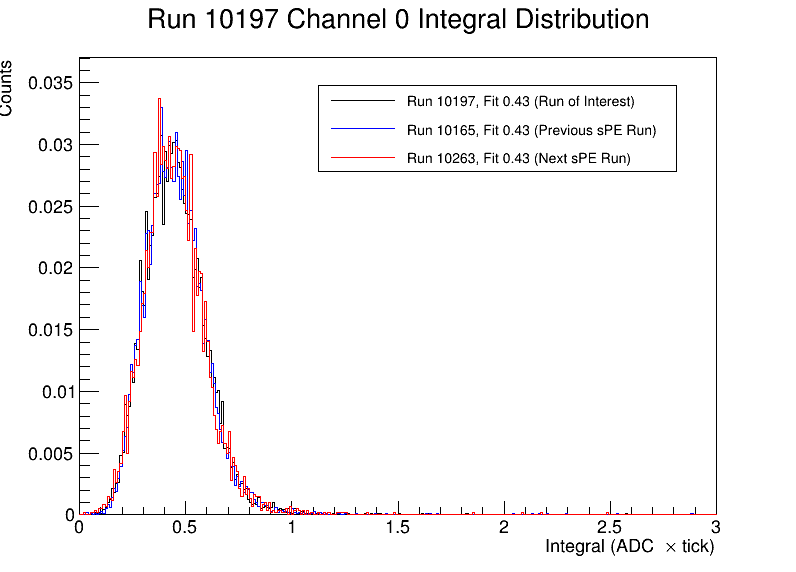

In [24]:
c1.Draw()

### Investigate sPE area fits for channels/runs with observed issues

10197, 9745/6, 9384, 9448, 9271, 9342 (and adjacent runs for comparison)

Matteo's histograms: /exp/icarus/data/users/mvicenzi/pmt-calibration/histograms/

In [11]:
fileDir = '/exp/icarus/data/users/mvicenzi/pmt-calibration/histograms/'
bad_runs = [9304, 9305, 9306, 9320, 9321, 9322, 9323, 9324, 9325, 9326, 9348, 9349, 9350, 9351, 9352, 9381, 9382, 9395, 9396, 9397, 9398, 9399, 9400, 9401, 9402, 9403, 9404, 9405, 9406, 9407, 9408, 9410, 9411, 9413, 9414, 9416, 9433, 9434, 9440, 9446, 9447, 9449, 9451, 9452, 9453, 9454, 9455, 9456, 9459, 9461, 9462, 9463, 9465, 9466, 9467, 9468, 9469, 9470, 9471, 9476, 9479, 9480, 9483, 9484, 9485, 9486, 9487, 9488, 9489, 9490, 9491, 9492, 9493, 9494, 9496, 9497, 9498, 9500, 9501, 9502, 9503, 9505, 9506, 9507, 9508, 9509, 9510, 9511, 9512, 9519, 9520, 9521, 9522, 9523, 9524, 9525, 9526, 9527, 9528, 9529, 9530, 9535, 9536, 9537, 9538, 9539, 9540, 9541, 9542, 9543, 9544, 9545, 9546, 9547, 9548, 9549, 9550, 9551, 9552, 9553, 9554, 9555, 9556, 9557, 9561, 9567, 9572, 9573, 9574, 9575, 9576, 9577, 9578, 9579, 9581, 9591, 9592, 9596, 9600, 9601, 9603, 9604, 9605, 9606, 9607, 9608, 9609, 9611, 9612, 9613, 9614, 9615, 9616, 9617, 9618, 9619, 9620, 9621, 9622, 9623, 9628, 9629, 9630, 9632, 9633, 9635, 9636, 9637, 9638, 9639, 9640, 9641, 9643, 9644, 9645, 9650, 9651, 9652, 9653, 9654, 9655, 9656, 9657, 9659, 9660, 9661, 9662, 9663, 9664, 9665, 9666, 9667, 9668, 9669, 9670, 9671, 9676, 9677, 9678, 9679, 9680, 9681, 9682, 9683, 9684, 9685, 9686, 9701, 9702, 9706, 9707, 9708, 9709, 9710, 9711, 9712, 9713, 9718, 9719, 9736, 9737, 9738, 9739, 9740, 9741, 9742, 9759, 9767, 9768, 9769, 9770, 9771, 9772, 9773, 9774, 9775, 9776, 9777, 9778, 9787, 9789, 9790, 9798, 9799, 9800, 9801, 9802, 9803, 9804, 9805, 9806, 9808, 9809, 9810, 9811, 9812, 9813, 9815, 9816, 9817, 9818, 9819, 9820, 9821, 9822, 9823, 9824, 9825, 9826, 9827, 9828, 9829, 9830, 9831, 9832, 9833, 9845, 9846, 9856, 9857, 9864, 9865, 9866, 9872, 9873, 9874, 9875, 9876, 9877, 9878, 9879, 9880, 9881, 9882, 9883, 9884, 9885, 9886, 9887, 9888, 9889, 9890, 9891, 9895, 9898, 9899, 9900, 9901, 9902, 9903, 9904, 9905, 9906, 9907, 9908, 9909, 9910, 9912, 9927, 9928, 9930, 9936, 9937, 9938, 9939, 9952, 9957, 9958, 9963, 9964, 9965, 9966, 9967, 9969, 9976, 9990, 9992, 9993, 9994, 9995, 9996, 9997, 9998, 9999, 10000, 10001, 10002, 10003, 10004, 10005, 10006, 10007, 10008, 10011, 10012, 10013, 10014, 10016, 10017, 10018, 10019, 10020, 10021, 10022, 10023, 10024, 10025, 10026, 10027, 10028, 10029, 10031, 10032, 10033, 10034, 10035, 10036, 10037, 10038, 10039, 10041, 10042, 10043, 10044, 10045, 10046, 10047, 10049, 10050, 10051, 10052, 10053, 10069, 10070, 10071, 10072, 10073, 10074, 10075, 10076, 10077, 10078, 10079, 10080, 10081, 10082, 10083]

fileDict = {}
for filename in os.listdir(fileDir):
    try:
        run = int(filename.split('run')[-1].split('.root')[0])
    except:
        continue
    if run in bad_runs:
        continue
    filePath = '/'.join([fileDir, filename])
    fileDict[run] = filePath

fileDict = dict(sorted(fileDict.items()))
fileDict

{8461: '/exp/icarus/data/users/mvicenzi/pmt-calibration/histograms//pulseDistributionHist_run8461.root',
 8469: '/exp/icarus/data/users/mvicenzi/pmt-calibration/histograms//pulseDistributionHist_run8469.root',
 8505: '/exp/icarus/data/users/mvicenzi/pmt-calibration/histograms//pulseDistributionHist_run8505.root',
 8515: '/exp/icarus/data/users/mvicenzi/pmt-calibration/histograms//pulseDistributionHist_run8515.root',
 8521: '/exp/icarus/data/users/mvicenzi/pmt-calibration/histograms//pulseDistributionHist_run8521.root',
 8530: '/exp/icarus/data/users/mvicenzi/pmt-calibration/histograms//pulseDistributionHist_run8530.root',
 8552: '/exp/icarus/data/users/mvicenzi/pmt-calibration/histograms//pulseDistributionHist_run8552.root',
 9271: '/exp/icarus/data/users/mvicenzi/pmt-calibration/histograms//pulseDistributionHist_run9271.root',
 9342: '/exp/icarus/data/users/mvicenzi/pmt-calibration/histograms//pulseDistributionHist_run9342.root',
 9383: '/exp/icarus/data/users/mvicenzi/pmt-calibration

In [38]:
c1 = r.TCanvas("c1", "c1", 800, 600)

r.gStyle.SetOptStat(0)

run = 10097
pmt = 214
scale = True
rebin = None

dictKeys = list(fileDict.keys())
arg = np.argwhere(np.array(dictKeys) == run)[0][0]

nextRun = dictKeys[arg + 1]
prevRun = dictKeys[arg - 1]

scaleFactor = (0.00488e-12) / (1e7 * 1.602e-19)
fit = gains[run][pmt] * scaleFactor
fitErr = gainsErr[run][pmt] * scaleFactor
fitPrev = gains[prevRun][pmt] * scaleFactor
fitErrPrev = gainsErr[prevRun][pmt] * scaleFactor
fitNext = gains[nextRun][pmt] * scaleFactor
fitErrNext = gainsErr[nextRun][pmt] * scaleFactor

fitScore = fits[run][pmt]
fitScorePrev = fits[prevRun][pmt]
fitScoreNext = fits[nextRun][pmt]

f1 = r.TFile.Open(fileDict[run], 'READ')
f2 = r.TFile.Open(fileDict[nextRun], 'READ')
f3 = r.TFile.Open(fileDict[prevRun], 'READ')

hIntegral = f1.Get(f"bkgcalibration/hintegral{pmt}")
hIntegralCut = f1.Get(f"bkgcalibration/hintegralcut{pmt}")

hIntegralPrev = f3.Get(f"bkgcalibration/hintegral{pmt}")
hIntegralCutPrev = f3.Get(f"bkgcalibration/hintegralcut{pmt}")
hIntegralNext = f2.Get(f"bkgcalibration/hintegral{pmt}")
hIntegralCutNext = f2.Get(f"bkgcalibration/hintegralcut{pmt}")

if scale:
    hIntegral.Scale(1.0 / hIntegral.Integral())
    hIntegralCut.Scale(1.0 / hIntegralCut.Integral())
    hIntegralPrev.Scale(1.0 / hIntegralPrev.Integral())
    hIntegralCutPrev.Scale(1.0 / hIntegralCutPrev.Integral())
    hIntegralNext.Scale(1.0 / hIntegralNext.Integral())
    hIntegralCutNext.Scale(1.0 / hIntegralCutNext.Integral())
if rebin is not None:
    hIntegral.Rebin(rebin)
    hIntegralCut.Rebin(rebin)
    hIntegralPrev.Rebin(rebin)
    hIntegralCutPrev.Rebin(rebin)
    hIntegralNext.Rebin(rebin)
    hIntegralCutNext.Rebin(rebin)

hIntegral.SetLineColor(r.kBlack)
hIntegralCut.SetLineColor(r.kBlack)
hIntegralPrev.SetLineColor(r.kBlue)
hIntegralCutPrev.SetLineColor(r.kBlue)
hIntegralNext.SetLineColor(r.kRed)
hIntegralCutNext.SetLineColor(r.kRed)

maxY = max(hIntegralCut.GetMaximum(), hIntegralCutPrev.GetMaximum(), hIntegralCutNext.GetMaximum())

hIntegralCut.SetTitle(f"Run {run} Channel {pmt} Integral Distribution;Integral (ADC #times tick);Counts")
if not scale:
    hIntegralCut.GetYaxis().SetRangeUser(0, 600)
else:
    hIntegralCut.GetYaxis().SetRangeUser(0, maxY * 1.1)
hIntegralCut.Draw("hist")
hIntegralCutPrev.Draw("hist same")
hIntegralCutNext.Draw("hist same")

l1 = r.TLegend(0.4, 0.7, 0.85, 0.85)
l1.AddEntry(hIntegralCut, f"Run {run}, Fit {fit:.2f} (Run of Interest)", "l")
l1.AddEntry(hIntegralCutPrev, f"Run {prevRun}, Fit {fitPrev:.2f} (Previous sPE Run)", "l")
l1.AddEntry(hIntegralCutNext, f"Run {nextRun}, Fit {fitNext:.2f} (Next sPE Run)", "l")
l1.Draw()

c1.Draw()

print(f"Run {run} Channel {pmt} Fit: {fit:.3f} +/- {fitErr:.3f}, Fit Quality: {fitScore:.3f}")
print(f"Prev Run {prevRun} Channel {pmt} Fit: {fitPrev:.3f} +/- {fitErrPrev:.3f}, Fit Quality: {fitScorePrev:.3f}")
print(f"Next Run {nextRun} Channel {pmt} Fit: {fitNext:.3f} +/- {fitErrNext:.3f}, Fit Quality: {fitScoreNext:.3f}")

Run 10097 Channel 214 Fit: 0.339 +/- 0.001, Fit Quality: 2.456
Prev Run 10058 Channel 214 Fit: 0.356 +/- 0.001, Fit Quality: 2.026
Next Run 10165 Channel 214 Fit: 0.322 +/- 0.001, Fit Quality: 1.893


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


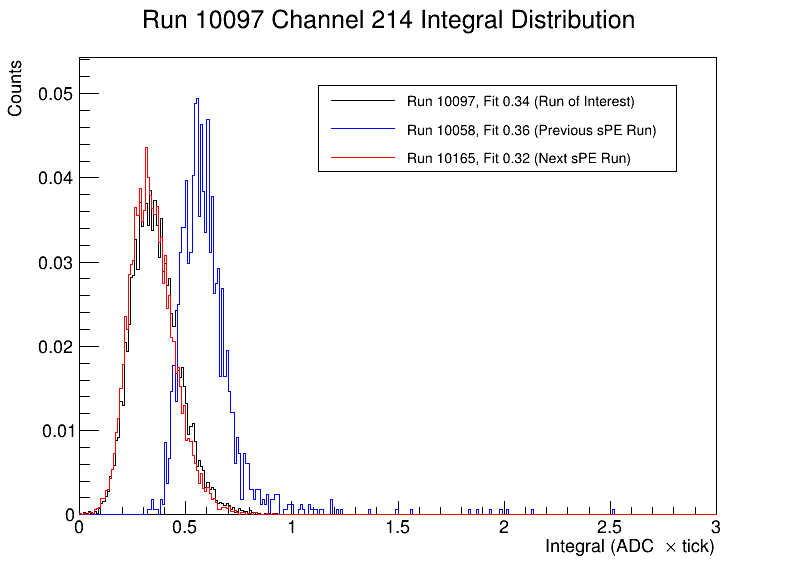

In [31]:
c1.Draw()

In [246]:
c1 = r.TCanvas("c1", "c1", 800, 600)

r.gStyle.SetOptStat(0)

run = 9745
pmt = 0
scale = True

dictKeys = list(fileDict.keys())
arg = np.argwhere(np.array(dictKeys) == run)[0][0]

nextRun = dictKeys[arg + 1]
prevRun = dictKeys[arg - 1]

fit = gains[run][chan] 
fitErr = gainsErr[run][chan]
fitPrev = gains[prevRun][chan]
fitErrPrev = gainsErr[prevRun][chan]
fitNext = gains[nextRun][chan]
fitErrNext = gainsErr[nextRun][chan]

f1 = r.TFile.Open(fileDict[run], 'READ')
f2 = r.TFile.Open(fileDict[nextRun], 'READ')
f3 = r.TFile.Open(fileDict[prevRun], 'READ')

hAmplitude = f1.Get(f"bkgcalibration/hamplitude{pmt}")

hAmplitudePrev = f3.Get(f"bkgcalibration/hamplitude{pmt}")
hAmplitudeNext = f2.Get(f"bkgcalibration/hamplitude{pmt}")
if scale:
    hAmplitude.Scale(1.0 / hAmplitude.Integral())
    hAmplitudePrev.Scale(1.0 / hAmplitudePrev.Integral())
    hAmplitudeNext.Scale(1.0 / hAmplitudeNext.Integral())

hAmplitude.SetLineColor(r.kBlack)
hAmplitudePrev.SetLineColor(r.kBlue)
hAmplitudeNext.SetLineColor(r.kRed)

maxY = max(hAmplitude.GetMaximum(), hAmplitudePrev.GetMaximum(), hAmplitudeNext.GetMaximum())

hAmplitude.SetTitle(f"Run {run} Channel {pmt} Amplitude Distribution;Amplitude (ADC);Counts")
if not scale:
    hAmplitude.GetYaxis().SetRangeUser(0, 600)
else:
    hAmplitude.GetYaxis().SetRangeUser(0, maxY * 1.1)
hAmplitude.Draw("hist")
hAmplitudePrev.Draw("hist same")
hAmplitudeNext.Draw("hist same")

l1 = r.TLegend(0.4, 0.7, 0.85, 0.85)
l1.AddEntry(hAmplitude, f"Run {run}, Fit {fit:.2f} (Run of Interest)", "l")
l1.AddEntry(hAmplitudePrev, f"Run {prevRun}, Fit {fitPrev:.2f} (Previous sPE Run)", "l")
l1.AddEntry(hAmplitudeNext, f"Run {nextRun}, Fit {fitNext:.2f} (Next sPE Run)", "l")
l1.Draw()

c1.Draw()

ampCutLow = 1.22
ampCutHigh = 4.0
hAmplitude.GetXaxis().SetRangeUser(ampCutLow, ampCutHigh)
hAmplitudePrev.GetXaxis().SetRangeUser(ampCutLow, ampCutHigh)
hAmplitudeNext.GetXaxis().SetRangeUser(ampCutLow, ampCutHigh)   

minbin = hAmplitude.GetMinimumBin()
minbinPrev = hAmplitudePrev.GetMinimumBin()
minbinNext = hAmplitudeNext.GetMinimumBin()

thresholds = hAmplitude.GetXaxis().GetBinCenter(minbin) 
thresholdsPrev = hAmplitudePrev.GetXaxis().GetBinCenter(minbinPrev)
thresholdsNext = hAmplitudeNext.GetXaxis().GetBinCenter(minbinNext)

print(f"Run {run} Channel {pmt} Threshold: {thresholds:.3f}")
print(f"Prev Run {prevRun} Channel {pmt} Threshold: {thresholdsPrev:.3f}")
print(f"Next Run {nextRun} Channel {pmt} Threshold: {thresholdsNext:.3f}")


Run 9745 Channel 0 Threshold: 1.729
Prev Run 9724 Channel 0 Threshold: 1.729
Next Run 9746 Channel 0 Threshold: 1.729


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


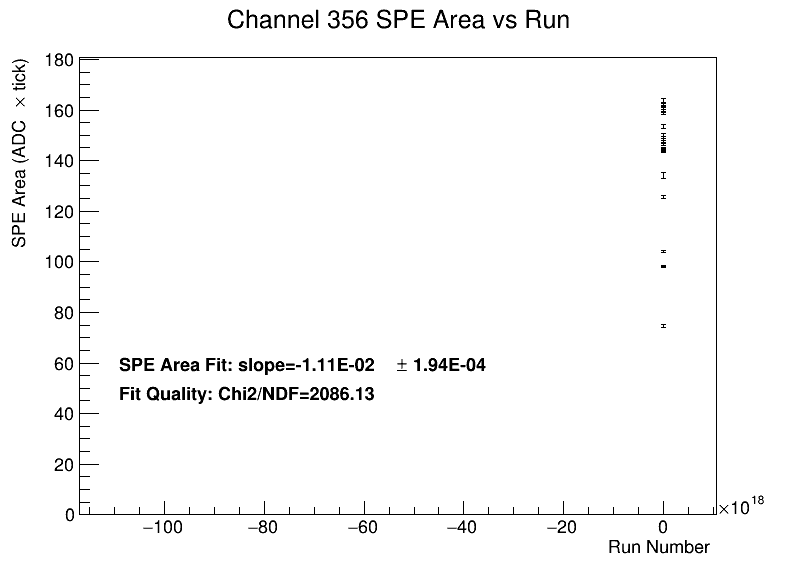

In [247]:
c1.Draw()

In [ ]:
fin = r.TFile.Open("/nashome/m/micarrig/icarus/pmt/v10_06_00_01p04/pmtPEHistograms.root", "UPDATE")
c1 = r.TCanvas("c1", "c1", 800, 600)

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


In [129]:
df[df['FitQuality'] > 100].to_csv('/nashome/m/micarrig/icarus/pmt/v10_06_00_01p04/badfits.csv')


In [49]:
h = fin.Get("run9327/NormalizedPE/h_normPE_run9327_chan0")
hRecal = fin.Get("run9327/RecalibratedPE/h_recalPE_run9327_chan0")

#fNorm = r.TF1("fNorm", "gaus", -5, 50)
fNorm = r.TF1("fNorm", "[0]*TMath::Power(([1]/[2]),(x/[2]))*(TMath::Exp(-([1]/[2])))/TMath::Gamma((x/[2])+1.)", 0, 5)
#fRecal = r.TF1("fRecal", "gaus", -5, 50)
fRecal = r.TF1("fRecal", "[0]*TMath::Power(([1]/[2]),(x/[2]))*(TMath::Exp(-([1]/[2])))/TMath::Gamma((x/[2])+1.)", 0, 5)

fNorm.SetParameters(10, 0.1, 0.2)
fRecal.SetParameters(10, 0.1, 0.2)
h.Fit(fNorm, "EMNR", "", 0.5, 4)
hRecal.Fit(fRecal, "EMNR", "", 0.5, 4)

hRecal.SetLineColor(r.kRed)
h.GetXaxis().SetRangeUser(0, 4)
h.Draw("hist")
hRecal.Draw("hist same")

fNorm.SetLineColor(r.kBlue)
fRecal.SetLineColor(r.kRed)
fNorm.Draw("same")
fRecal.Draw("same")

c1.Draw()

NameError: name 'fin' is not defined

### plot the bad fit channels as a function of their location

In [102]:
pos = pd.read_csv('/nashome/m/micarrig/icarus/pmt/v10_06_00_01p04/pmt_positions.csv')
#pos[(abs(pos['pmt_x']) != 371.07) & (abs(pos['pmt_x']) != 49.36)]
ybin = pos['pmt_y'].to_list()
ybin = sorted(list(set(ybin)))

zbin = pos['pmt_z'].to_list()
zbin = sorted(list(set(zbin)))

firstBinY = min(ybin)
lastBinY = max(ybin)
binWidthY = ybin[1] - ybin[0]
nBinsY = round((lastBinY - firstBinY) / binWidthY) + 1

firstBinZ = min(zbin)
lastBinZ = max(zbin)
binWidthZ = zbin[1] - zbin[0]
nBinsZ = round((lastBinZ - firstBinZ) / binWidthZ) + 1

xbin = pos['pmt_x'].to_list()
xbin = sorted(list(set(xbin)))

print("nBinsY", nBinsY, "firstBinY", firstBinY, "lastBinY", lastBinY, "binWidthY", binWidthY)
print("nBinsZ", nBinsZ, "firstBinZ", firstBinZ, "lastBinZ", lastBinZ, "binWidthZ", binWidthZ)
print(xbin)

ymin = firstBinY - binWidthY / 2
ymax = lastBinY + binWidthY / 2
zmin = firstBinZ - binWidthZ / 2
zmax = lastBinZ + binWidthZ / 2

df['fit'] = df['Chi2'] / df['NDF']
df['fit_recal'] = df['Chi2_recal'] / df['NDF_recal']


nBinsY 5 firstBinY -129.05 lastBinY 82.15 binWidthY 52.80000000000001
nBinsZ 36 firstBinZ -872.9 lastBinZ 872.9 binWidthZ 49.879999999999995
[-371.07, -49.36, 49.36, 371.07]


In [103]:
h_EE = r.TH2F("h_EE", "PMT Positions EE;Y (cm);Z (cm)", nBinsY, ymin, ymax, nBinsZ, zmin, zmax)
h_EW = r.TH2F("h_EW", "PMT Positions EW;Y (cm);Z (cm)", nBinsY, ymin, ymax, nBinsZ, zmin, zmax)
h_WE = r.TH2F("h_WE", "PMT Positions WE;Y (cm);Z (cm)", nBinsY, ymin, ymax, nBinsZ, zmin, zmax)
h_WW = r.TH2F("h_WW", "PMT Positions WW;Y (cm);Z (cm)", nBinsY, ymin, ymax, nBinsZ, zmin, zmax)

In [104]:
pd.set_option('display.max_rows', None)
pos

,entry,subentry,pmt_x,pmt_y,pmt_z
0,0,0,-371.07,-76.25,-872.90
1,0,1,-371.07,29.35,-872.90
2,0,2,-371.07,-129.05,-823.02
3,0,3,-371.07,-23.45,-823.02
4,0,4,-371.07,82.15,-823.02
5,0,5,-371.07,-129.05,-773.14
6,0,6,-371.07,-23.45,-773.14
7,0,7,-371.07,82.15,-773.14
8,0,8,-371.07,-76.25,-723.26
9,0,9,-371.07,29.35,-723.26


In [105]:
for ch in pos['subentry'].to_list():
    x = pos['pmt_x'][pos['subentry'] == ch].values[0]
    y = pos['pmt_y'][pos['subentry'] == ch].values[0]
    z = pos['pmt_z'][pos['subentry'] == ch].values[0]
    if x == -371.07:
        h_EE.Fill(y, z, ch)
    elif x == -49.36:
        h_EW.Fill(y, z, ch)
    elif x == 49.36:
        h_WE.Fill(y, z, ch)
    elif x == 371.07:
        h_WW.Fill(y, z, ch)

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


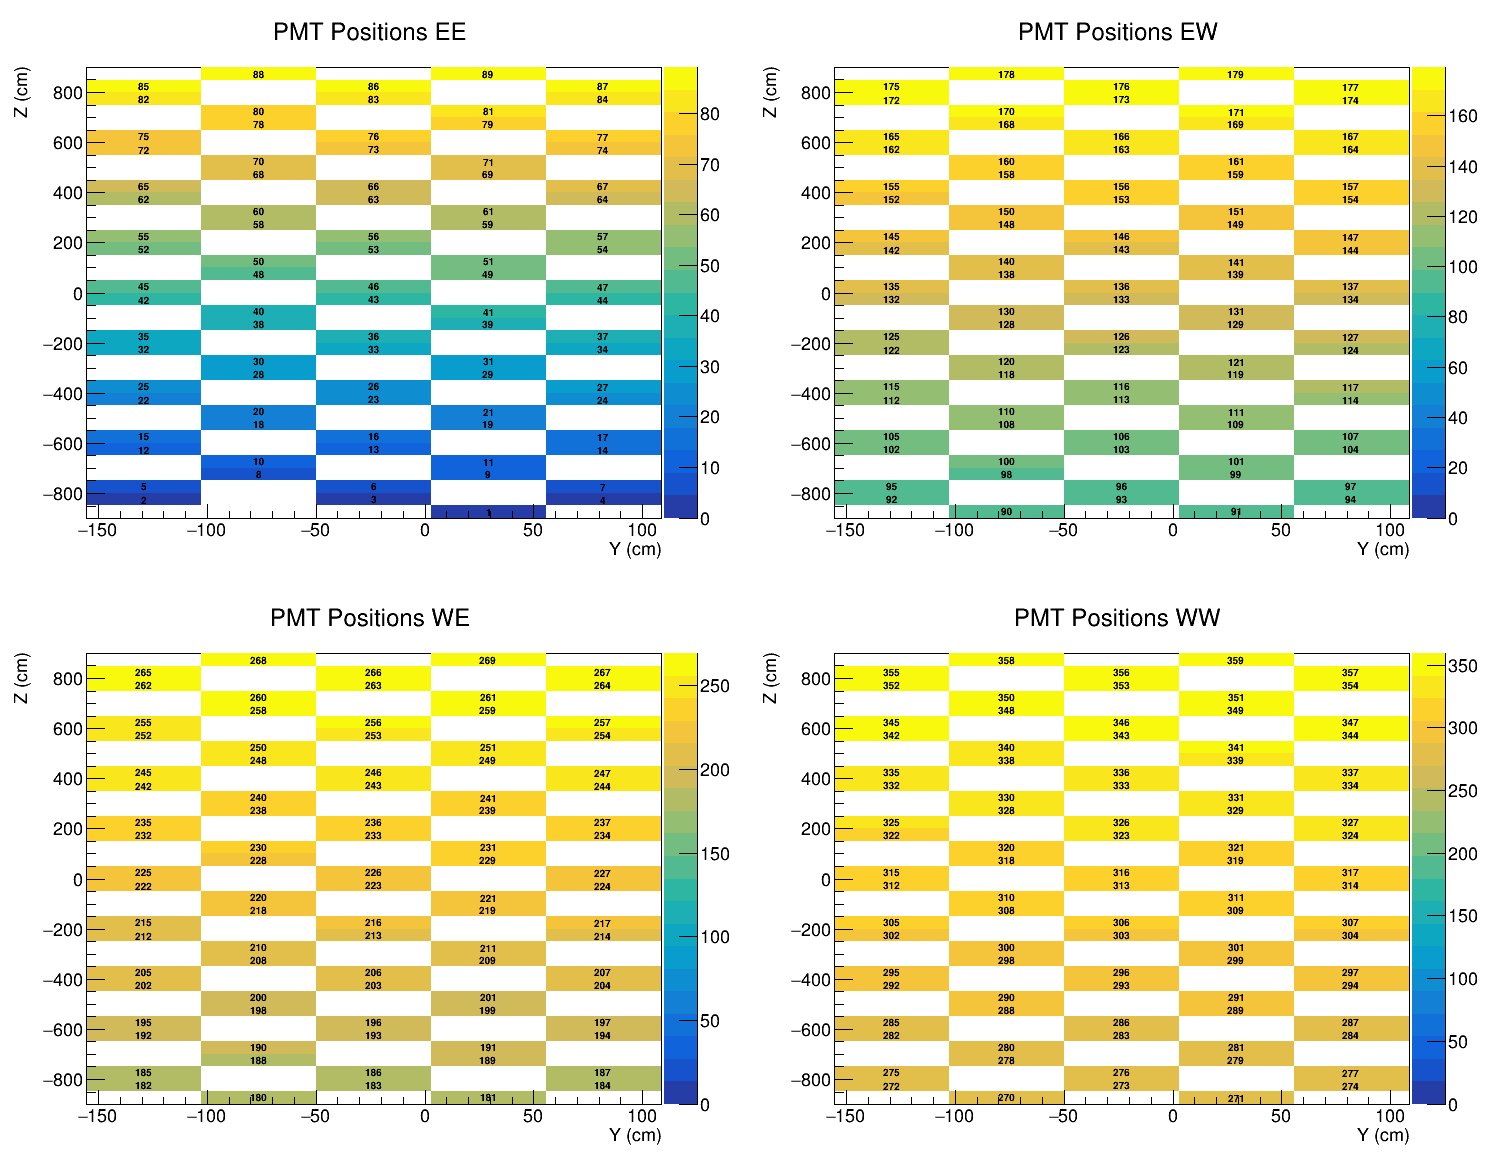

In [106]:
r.gStyle.SetOptStat(0)
c1 = r.TCanvas("c1", "PMT Positions EE", 1500, 1200)
c1.Divide(2, 2)
c1.cd(1)
h_EE.Draw("COLZ TEXT")
c1.cd(2)
h_EW.Draw("COLZ TEXT")
c1.cd(3)
h_WE.Draw("COLZ TEXT")
c1.cd(4)
h_WW.Draw("COLZ TEXT")
c1.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


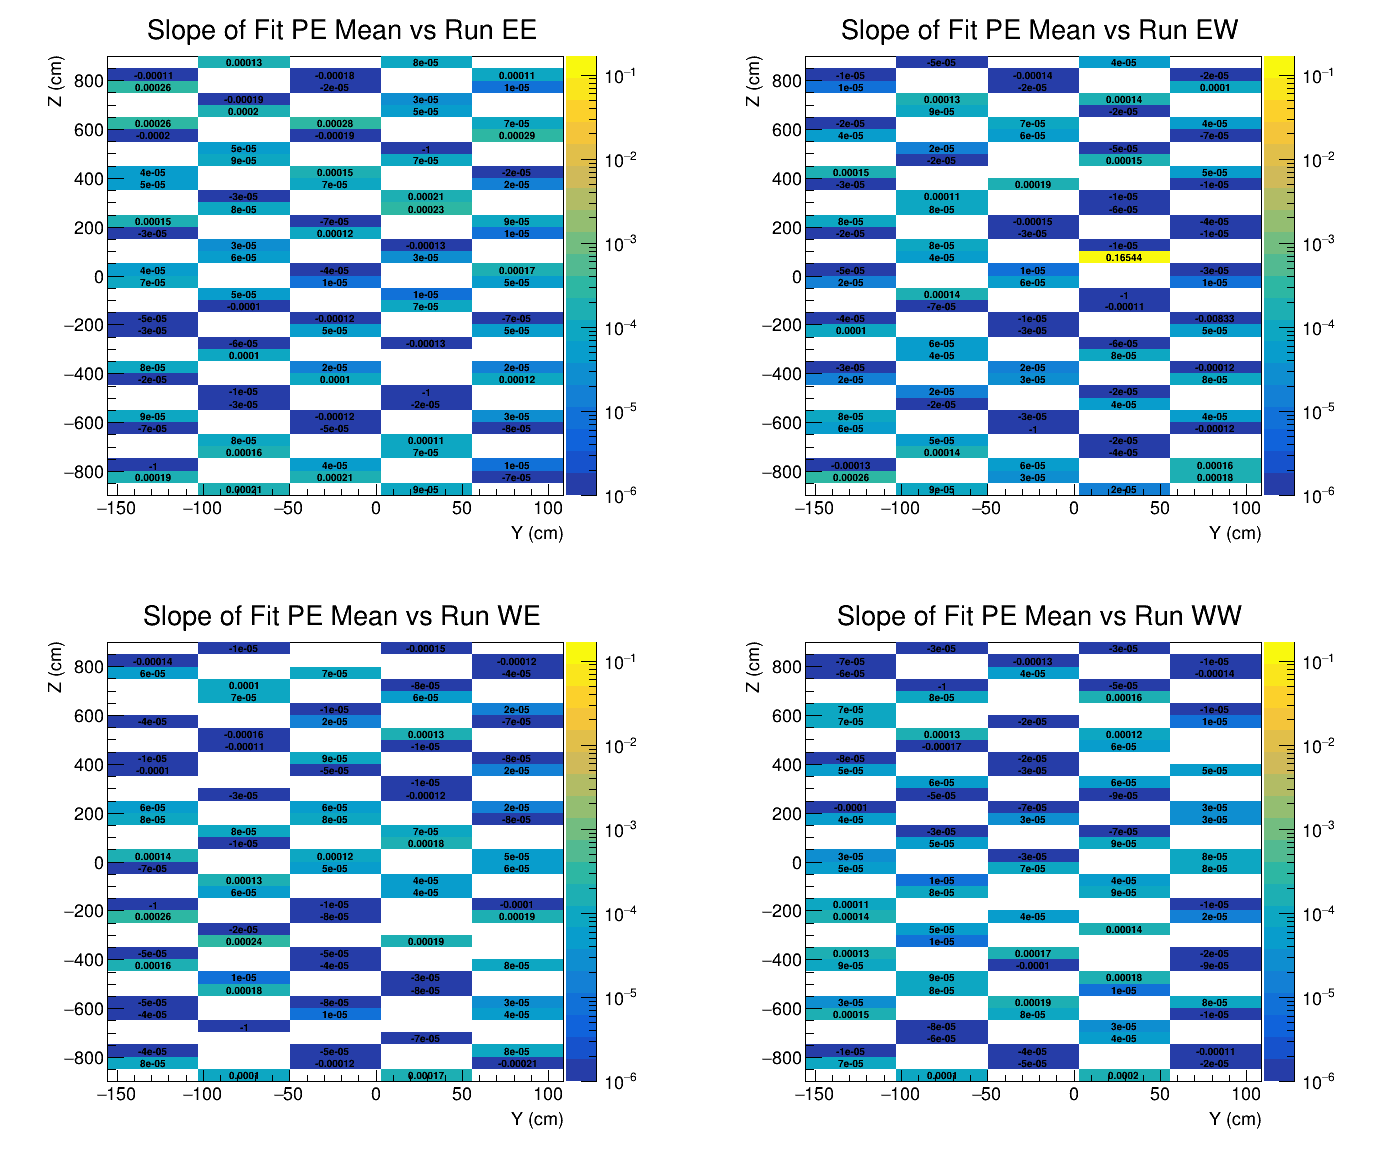

In [116]:
title = "Slope of Fit PE Mean vs Run"
h_EE.Reset()
h_EW.Reset()
h_WE.Reset()
h_WW.Reset()
for ch in df['Channel'].to_list():
    x = pos['pmt_x'][pos['subentry'] == ch].values[0]
    y = pos['pmt_y'][pos['subentry'] == ch].values[0]
    z = pos['pmt_z'][pos['subentry'] == ch].values[0]
    val = df['SlopeMean'][df['Channel'] == ch].values[0]
    if x == -371.07:
        h_EE.Fill(y, z, val)
    elif x == -49.36:
        h_EW.Fill(y, z, val)
    elif x == 49.36:
        h_WE.Fill(y, z, val)
    elif x == 371.07:
        h_WW.Fill(y, z, val)

zmin = 1e-6
zmax = df['SlopeMean'].max()
h_EE.GetZaxis().SetRangeUser(zmin, zmax)
h_EW.GetZaxis().SetRangeUser(zmin, zmax)
h_WE.GetZaxis().SetRangeUser(zmin, zmax)
h_WW.GetZaxis().SetRangeUser(zmin, zmax)

r.gStyle.SetOptStat(0)
c1 = r.TCanvas("c1", "PMT Positions EE", 1400, 1200)
c1.Divide(2, 2)
c1.cd(1)
r.gPad.SetLeftMargin(0.14)
r.gPad.SetBottomMargin(0.14)
r.gPad.SetRightMargin(0.18)
r.gPad.SetTopMargin(0.08)
h_EE.SetTitle(f"{title} EE")
h_EE.GetXaxis().SetTitleOffset(1.2)
h_EE.GetYaxis().SetTitleOffset(1.4)
h_EE.GetZaxis().SetTitleOffset(1.2)
h_EE.Draw("COLZ TEXT")
r.gPad.SetLogz()
c1.cd(2)
r.gPad.SetLeftMargin(0.14)
r.gPad.SetBottomMargin(0.14)
r.gPad.SetRightMargin(0.18)
r.gPad.SetTopMargin(0.08)
h_EW.SetTitle(f"{title} EW")
h_EW.GetXaxis().SetTitleOffset(1.2)
h_EW.GetYaxis().SetTitleOffset(1.4)
h_EW.GetZaxis().SetTitleOffset(1.2)
h_EW.Draw("COLZ TEXT")
r.gPad.SetLogz()
c1.cd(3)
r.gPad.SetLeftMargin(0.14)
r.gPad.SetBottomMargin(0.14)
r.gPad.SetRightMargin(0.18)
r.gPad.SetTopMargin(0.08)
h_WE.SetTitle(f"{title} WE")
h_WE.Draw("COLZ TEXT")
h_WE.GetXaxis().SetTitleOffset(1.2)
h_WE.GetYaxis().SetTitleOffset(1.4)
h_WE.GetZaxis().SetTitleOffset(1.2)
r.gPad.SetLogz()
c1.cd(4)
r.gPad.SetLeftMargin(0.14)
r.gPad.SetBottomMargin(0.14)
r.gPad.SetRightMargin(0.18)
r.gPad.SetTopMargin(0.08)
h_WW.SetTitle(f"{title} WW")
h_WW.Draw("COLZ TEXT")
h_WW.GetXaxis().SetTitleOffset(1.2)
h_WW.GetYaxis().SetTitleOffset(1.4)
h_WW.GetZaxis().SetTitleOffset(1.2)
r.gPad.SetLogz()
c1.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


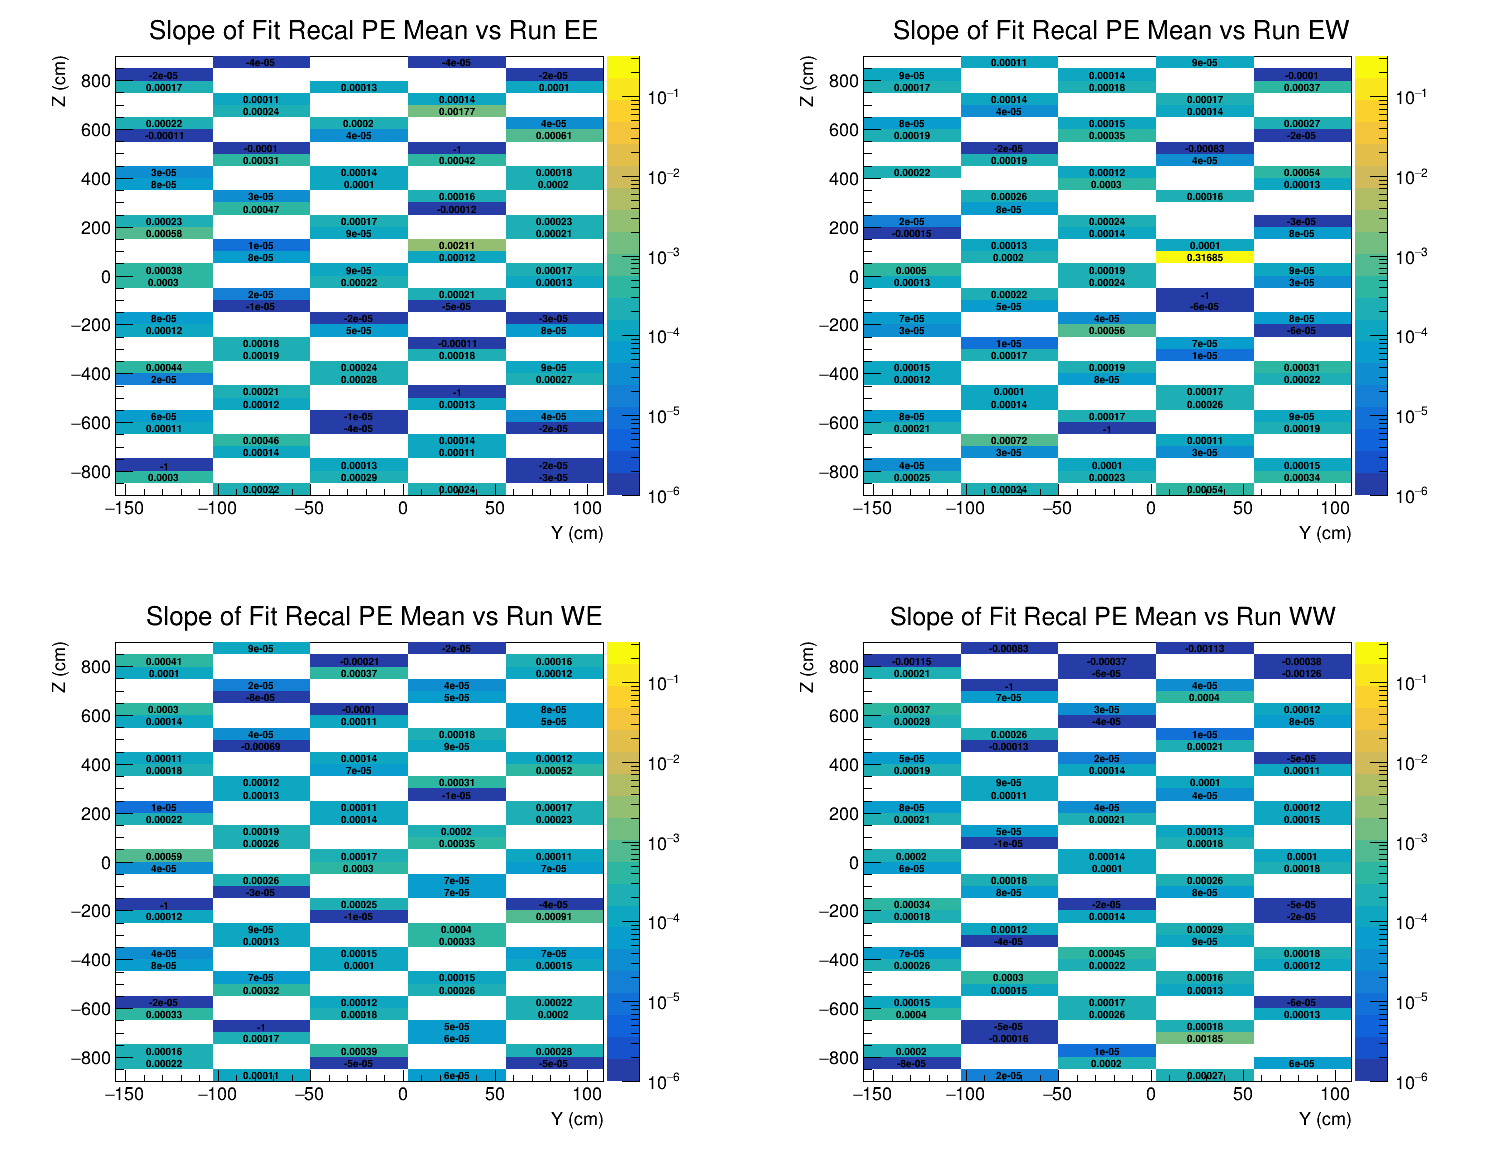

In [117]:
title = "Slope of Fit Recal PE Mean vs Run"
h_EE.Reset()
h_EW.Reset()
h_WE.Reset()
h_WW.Reset()
for ch in df['Channel'].to_list():
    x = pos['pmt_x'][pos['subentry'] == ch].values[0]
    y = pos['pmt_y'][pos['subentry'] == ch].values[0]
    z = pos['pmt_z'][pos['subentry'] == ch].values[0]
    val = df['SlopeMeanRecal'][df['Channel'] == ch].values[0]
    if x == -371.07:
        h_EE.Fill(y, z, val)
    elif x == -49.36:
        h_EW.Fill(y, z, val)
    elif x == 49.36:
        h_WE.Fill(y, z, val)
    elif x == 371.07:
        h_WW.Fill(y, z, val)

zmin = 1e-6
zmax = df['SlopeMeanRecal'].max()
h_EE.GetZaxis().SetRangeUser(zmin, zmax)
h_EW.GetZaxis().SetRangeUser(zmin, zmax)
h_WE.GetZaxis().SetRangeUser(zmin, zmax)
h_WW.GetZaxis().SetRangeUser(zmin, zmax)

r.gStyle.SetOptStat(0)
c1 = r.TCanvas("c1", "PMT Positions EE", 1500, 1200)
c1.Divide(2, 2)
c1.cd(1)
r.gPad.SetLeftMargin(0.14)
r.gPad.SetBottomMargin(0.14)
r.gPad.SetRightMargin(0.18)
r.gPad.SetTopMargin(0.08)
h_EE.SetTitle(f"{title} EE")
h_EE.GetXaxis().SetTitleOffset(1.2)
h_EE.GetYaxis().SetTitleOffset(1.4)
h_EE.GetZaxis().SetTitleOffset(1.2)
h_EE.Draw("COLZ TEXT")
r.gPad.SetLogz()
c1.cd(2)
r.gPad.SetLeftMargin(0.14)
r.gPad.SetBottomMargin(0.14)
r.gPad.SetRightMargin(0.18)
r.gPad.SetTopMargin(0.08)
h_EW.SetTitle(f"{title} EW")
h_EW.GetXaxis().SetTitleOffset(1.2)
h_EW.GetYaxis().SetTitleOffset(1.4)
h_EW.GetZaxis().SetTitleOffset(1.2)
h_EW.Draw("COLZ TEXT")
r.gPad.SetLogz()
c1.cd(3)
r.gPad.SetLeftMargin(0.14)
r.gPad.SetBottomMargin(0.14)
r.gPad.SetRightMargin(0.18)
r.gPad.SetTopMargin(0.08)
h_WE.SetTitle(f"{title} WE")
h_WE.Draw("COLZ TEXT")
h_WE.GetXaxis().SetTitleOffset(1.2)
h_WE.GetYaxis().SetTitleOffset(1.4)
h_WE.GetZaxis().SetTitleOffset(1.2)
r.gPad.SetLogz()
c1.cd(4)
r.gPad.SetLeftMargin(0.14)
r.gPad.SetBottomMargin(0.14)
r.gPad.SetRightMargin(0.18)
r.gPad.SetTopMargin(0.08)
h_WW.SetTitle(f"{title} WW")
h_WW.Draw("COLZ TEXT")
h_WW.GetXaxis().SetTitleOffset(1.2)
h_WW.GetYaxis().SetTitleOffset(1.4)
h_WW.GetZaxis().SetTitleOffset(1.2)
r.gPad.SetLogz()
c1.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


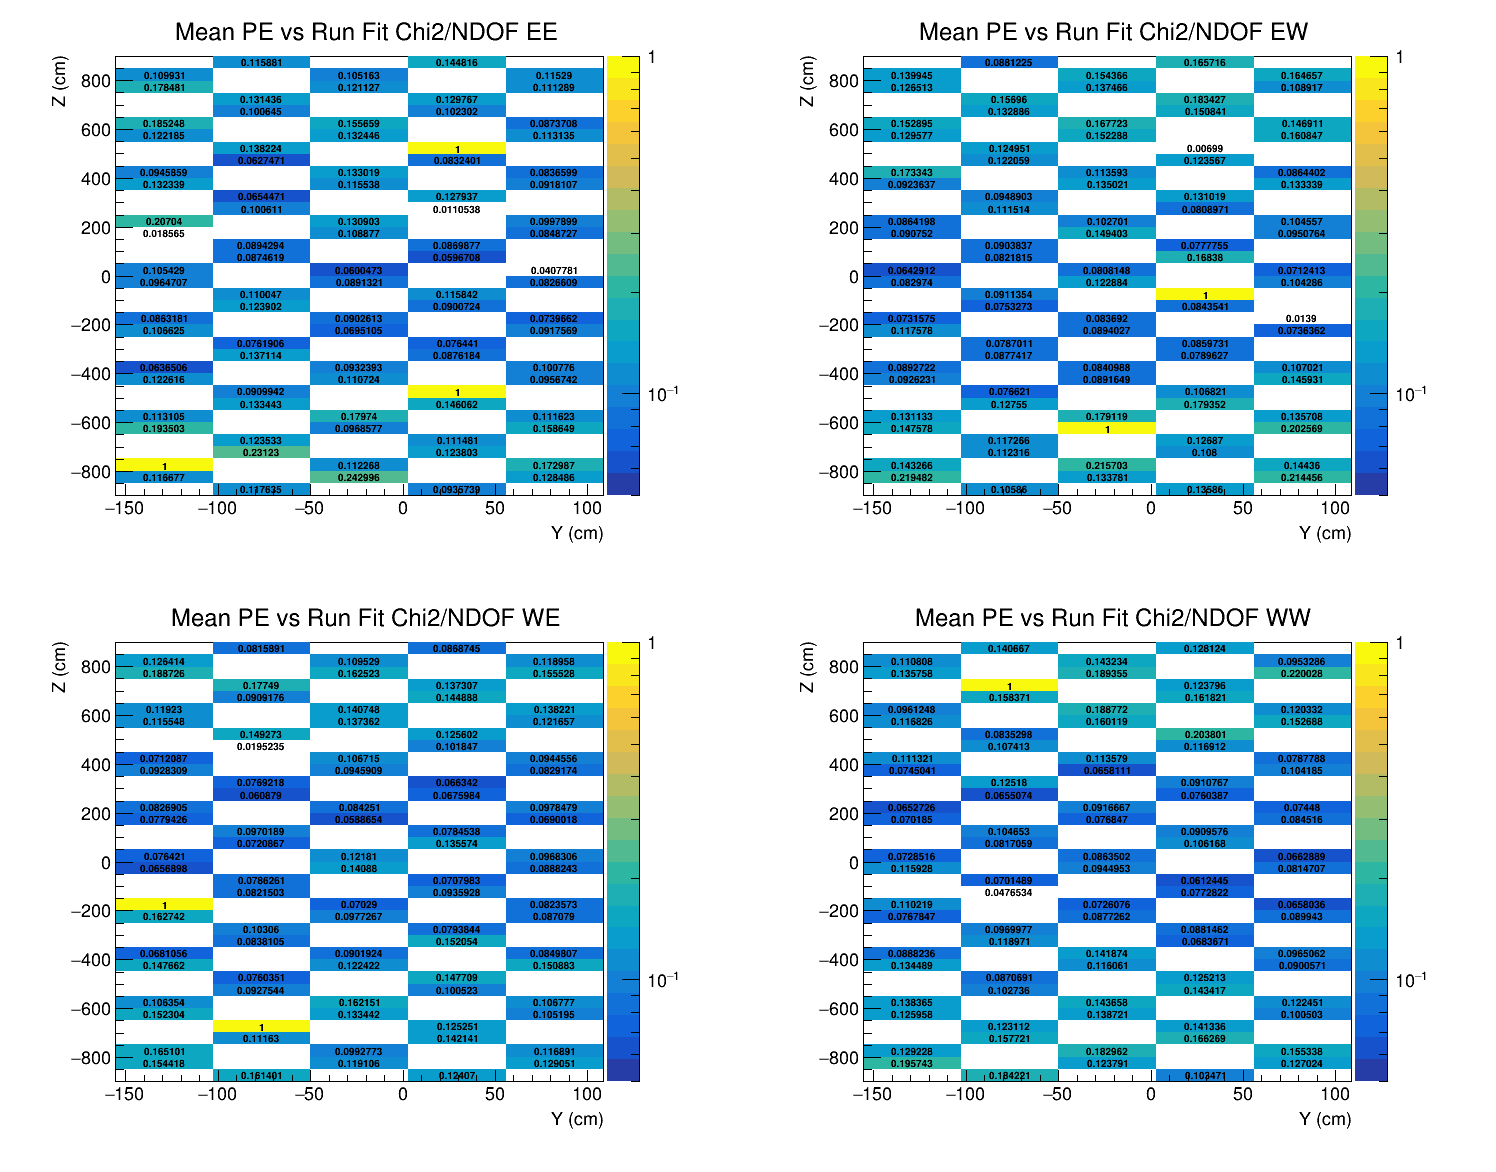

In [118]:
title = "Mean PE vs Run Fit Chi2/NDOF"

h_EE.Reset()
h_EW.Reset()
h_WE.Reset()
h_WW.Reset()
for ch in df['Channel'].to_list():
    x = pos['pmt_x'][pos['subentry'] == ch].values[0]
    y = pos['pmt_y'][pos['subentry'] == ch].values[0]
    z = pos['pmt_z'][pos['subentry'] == ch].values[0]
    val = df['fit'][df['Channel'] == ch].values[0]
    if x == -371.07:
        h_EE.Fill(y, z, val)
    elif x == -49.36:
        h_EW.Fill(y, z, val)
    elif x == 49.36:
        h_WE.Fill(y, z, val)
    elif x == 371.07:
        h_WW.Fill(y, z, val)

zmin = 0.05
zmax = df['fit'].max()
h_EE.GetZaxis().SetRangeUser(zmin, zmax)
h_EW.GetZaxis().SetRangeUser(zmin, zmax)
h_WE.GetZaxis().SetRangeUser(zmin, zmax)
h_WW.GetZaxis().SetRangeUser(zmin, zmax)

r.gStyle.SetOptStat(0)
c1 = r.TCanvas("c1", "PMT Chi2/NDOF EE", 1500, 1200)
c1.Divide(2, 2)
c1.cd(1)
c1.cd(1)
r.gPad.SetLeftMargin(0.14)
r.gPad.SetBottomMargin(0.14)
r.gPad.SetRightMargin(0.18)
r.gPad.SetTopMargin(0.08)
h_EE.SetTitle(f"{title} EE")
h_EE.GetXaxis().SetTitleOffset(1.2)
h_EE.GetYaxis().SetTitleOffset(1.4)
h_EE.GetZaxis().SetTitleOffset(1.2)
h_EE.Draw("COLZ TEXT")
r.gPad.SetLogz()
c1.cd(2)
r.gPad.SetLeftMargin(0.14)
r.gPad.SetBottomMargin(0.14)
r.gPad.SetRightMargin(0.18)
r.gPad.SetTopMargin(0.08)
h_EW.SetTitle(f"{title} EW")
h_EW.GetXaxis().SetTitleOffset(1.2)
h_EW.GetYaxis().SetTitleOffset(1.4)
h_EW.GetZaxis().SetTitleOffset(1.2)
h_EW.Draw("COLZ TEXT")
r.gPad.SetLogz()
c1.cd(3)
r.gPad.SetLeftMargin(0.14)
r.gPad.SetBottomMargin(0.14)
r.gPad.SetRightMargin(0.18)
r.gPad.SetTopMargin(0.08)
h_WE.SetTitle(f"{title} WE")
h_WE.Draw("COLZ TEXT")
h_WE.GetXaxis().SetTitleOffset(1.2)
h_WE.GetYaxis().SetTitleOffset(1.4)
h_WE.GetZaxis().SetTitleOffset(1.2)
r.gPad.SetLogz()
c1.cd(4)
r.gPad.SetLeftMargin(0.14)
r.gPad.SetBottomMargin(0.14)
r.gPad.SetRightMargin(0.18)
r.gPad.SetTopMargin(0.08)
h_WW.SetTitle(f"{title} WW")
h_WW.Draw("COLZ TEXT")
h_WW.GetXaxis().SetTitleOffset(1.2)
h_WW.GetYaxis().SetTitleOffset(1.4)
h_WW.GetZaxis().SetTitleOffset(1.2)
r.gPad.SetLogz()
c1.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


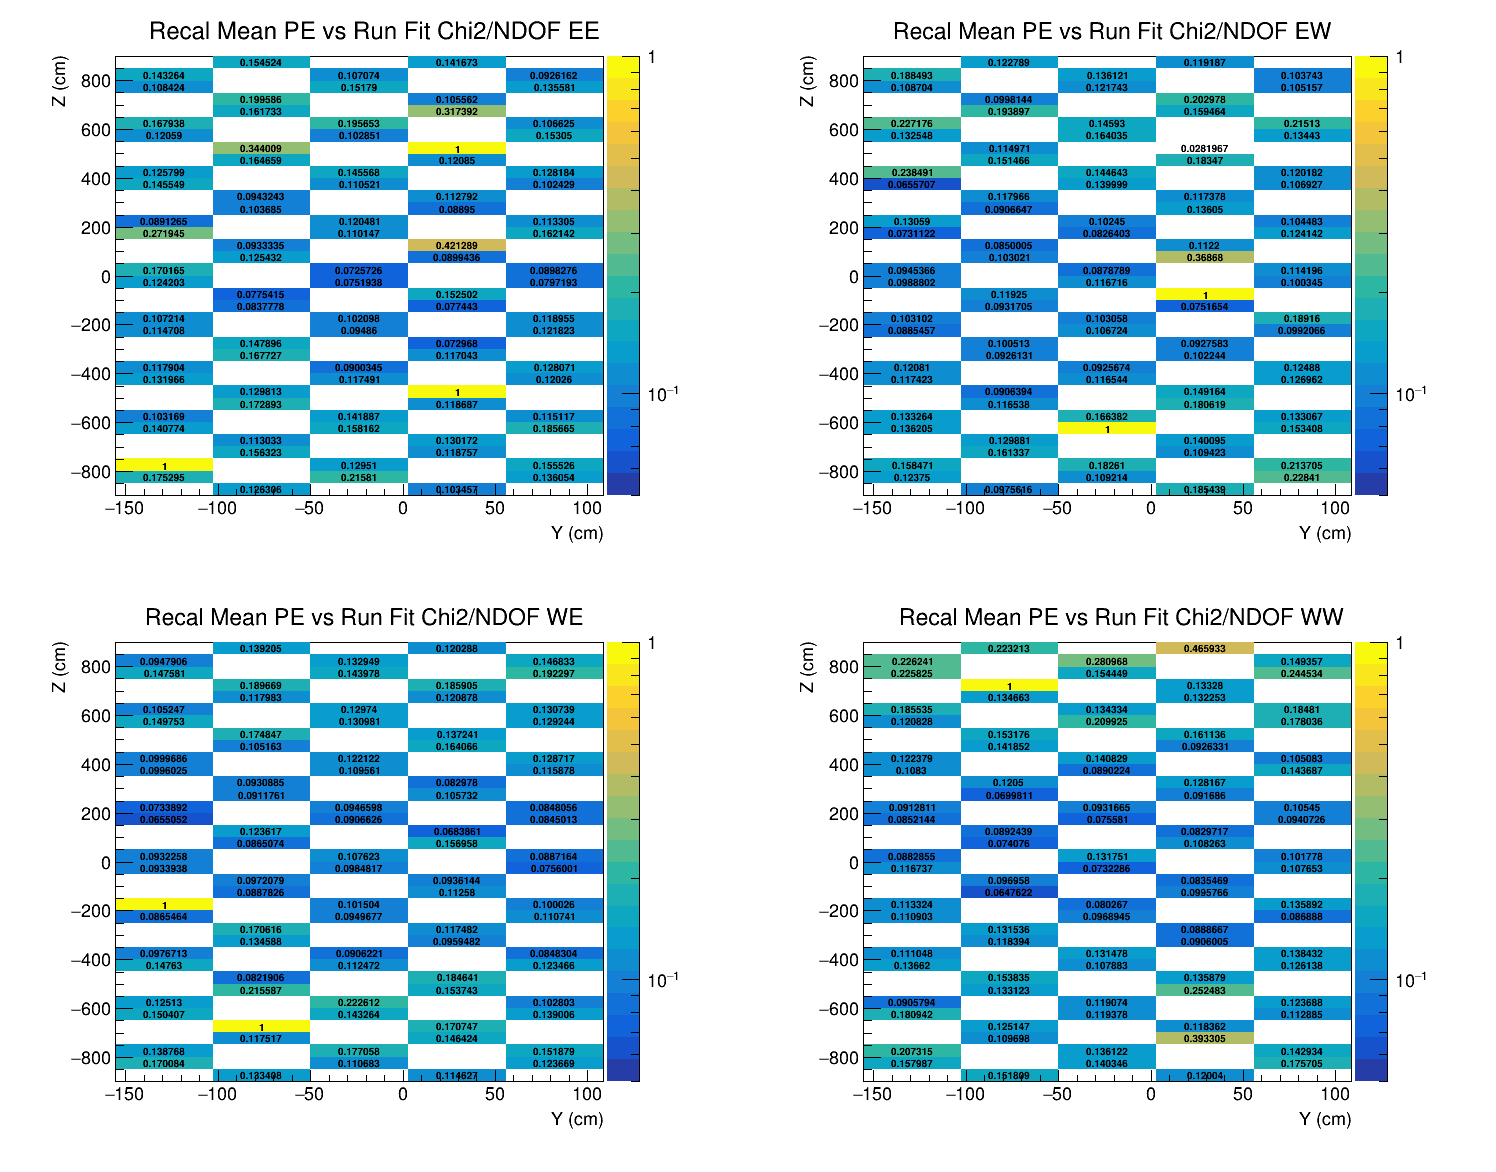

In [119]:
title = "Recal Mean PE vs Run Fit Chi2/NDOF"

h_EE.Reset()
h_EW.Reset()
h_WE.Reset()
h_WW.Reset()
for ch in df['Channel'].to_list():
    x = pos['pmt_x'][pos['subentry'] == ch].values[0]
    y = pos['pmt_y'][pos['subentry'] == ch].values[0]
    z = pos['pmt_z'][pos['subentry'] == ch].values[0]
    val = df['fit_recal'][df['Channel'] == ch].values[0]
    if x == -371.07:
        h_EE.Fill(y, z, val)
    elif x == -49.36:
        h_EW.Fill(y, z, val)
    elif x == 49.36:
        h_WE.Fill(y, z, val)
    elif x == 371.07:
        h_WW.Fill(y, z, val)

zmin = 0.05
zmax = df['fit_recal'].max()
h_EE.GetZaxis().SetRangeUser(zmin, zmax)
h_EW.GetZaxis().SetRangeUser(zmin, zmax)
h_WE.GetZaxis().SetRangeUser(zmin, zmax)
h_WW.GetZaxis().SetRangeUser(zmin, zmax)

r.gStyle.SetOptStat(0)
c1 = r.TCanvas("c1", "PMT Chi2/NDOF EE", 1500, 1200)
c1.Divide(2, 2)
c1.cd(1)
r.gPad.SetLeftMargin(0.14)
r.gPad.SetBottomMargin(0.14)
r.gPad.SetRightMargin(0.18)
r.gPad.SetTopMargin(0.08)
h_EE.SetTitle(f"{title} EE")
h_EE.GetXaxis().SetTitleOffset(1.2)
h_EE.GetYaxis().SetTitleOffset(1.4)
h_EE.GetZaxis().SetTitleOffset(1.2)
h_EE.Draw("COLZ TEXT")
r.gPad.SetLogz()
c1.cd(2)
r.gPad.SetLeftMargin(0.14)
r.gPad.SetBottomMargin(0.14)
r.gPad.SetRightMargin(0.18)
r.gPad.SetTopMargin(0.08)
h_EW.SetTitle(f"{title} EW")
h_EW.GetXaxis().SetTitleOffset(1.2)
h_EW.GetYaxis().SetTitleOffset(1.4)
h_EW.GetZaxis().SetTitleOffset(1.2)
h_EW.Draw("COLZ TEXT")
r.gPad.SetLogz()
c1.cd(3)
r.gPad.SetLeftMargin(0.14)
r.gPad.SetBottomMargin(0.14)
r.gPad.SetRightMargin(0.18)
r.gPad.SetTopMargin(0.08)
h_WE.SetTitle(f"{title} WE")
h_WE.Draw("COLZ TEXT")
h_WE.GetXaxis().SetTitleOffset(1.2)
h_WE.GetYaxis().SetTitleOffset(1.4)
h_WE.GetZaxis().SetTitleOffset(1.2)
r.gPad.SetLogz()
c1.cd(4)
r.gPad.SetLeftMargin(0.14)
r.gPad.SetBottomMargin(0.14)
r.gPad.SetRightMargin(0.18)
r.gPad.SetTopMargin(0.08)
h_WW.SetTitle(f"{title} WW")
h_WW.Draw("COLZ TEXT")
h_WW.GetXaxis().SetTitleOffset(1.2)
h_WW.GetYaxis().SetTitleOffset(1.4)
h_WW.GetZaxis().SetTitleOffset(1.2)
r.gPad.SetLogz()
c1.Draw()

In [2]:
fin = r.TFile.Open("root://fndcadoor.fnal.gov/sbn/data/sbn_fd/poms_production/data/Reproc_Run2_SBN/reconstructed/icaruscode_v10_06_00_01p05/bnbmajority/calibtuples/09/5f/hist_compressed_data_dl3_fstrmBNBMAJORITY_run9309_4_20250709T164744_bnb_20250709T170210_stage1_caf_larcv-53daa755-e260-4c6d-aa43-d2a7eb8ed78c.root")
tree = fin.Get("simpleLightAna/ophit_ttree")
tE = fin.Get("simpleLightAna/opflashCryoE_flashtree")

Warning in <TClass::Init>: no dictionary for class sbn::TrackInfo is available
Warning in <TClass::Init>: no dictionary for class sbn::MetaInfo is available
Warning in <TClass::Init>: no dictionary for class sbn::TrackHitInfo is available
Warning in <TClass::Init>: no dictionary for class sbn::HitInfo is available
Warning in <TClass::Init>: no dictionary for class sbn::Vector3D is available
Warning in <TClass::Init>: no dictionary for class sbn::HitTruth is available
Warning in <TClass::Init>: no dictionary for class sbn::WireInfo is available
Warning in <TClass::Init>: no dictionary for class sbn::TrackTruth is available
Warning in <TClass::Init>: no dictionary for class sbn::TrueParticle is available
Warning in <TClass::Init>: no dictionary for class sbn::TrueHit is available


In [7]:
tE.Print()

******************************************************************************
*Tree    :opflashCryoE_flashtree: TTree for the recob::Flashes with label opflashCryoE   *
*Entries :      159 : Total =         2567379 bytes  File  Size =     337939 *
*        :          : Tree compression factor =   7.62                       *
******************************************************************************
*Br    0 :run       : run/I                                                  *
*Entries :      159 : Total  Size=       1201 bytes  File Size  =        117 *
*Baskets :        1 : Basket Size=      32000 bytes  Compression=   6.19     *
*............................................................................*
*Br    1 :event     : event/I                                                *
*Entries :      159 : Total  Size=       1211 bytes  File Size  =        189 *
*Baskets :        1 : Basket Size=      32000 bytes  Compression=   3.84     *
*.......................................

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


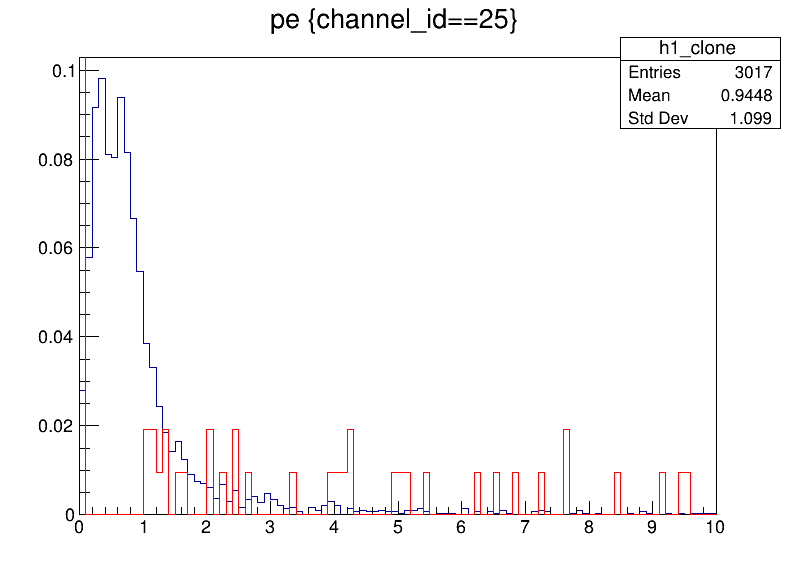

In [11]:
tree.Draw("pe>>h1(100,0,10)", "channel_id==25")
tE.Draw("pe_pmt[25]>>h2(100,0,10)")
h1 = r.gDirectory.Get("h1")
h2 = r.gDirectory.Get("h2")

# Clone the histograms so they persist after closing the file
h1_clone = h1.Clone("h1_clone")
h1_clone.SetDirectory(0)  # Detach from file

h2_clone = h2.Clone("h2_clone")
h2_clone.SetDirectory(0)  # Detach from file

h1_clone.Scale(1.0 / h1_clone.Integral())
h2_clone.Scale(1.0 / h2_clone.Integral())

c1 = r.TCanvas("c1", "Hit Integral", 800, 600)
h1_clone.Draw("hist")   
h2_clone.SetLineColor(r.kRed)
h2_clone.Draw("same hist")
c1.Draw()

In [22]:
fin = uproot.open("root://fndcadoor.fnal.gov/sbn/data/sbn_fd/poms_production/data/Reproc_Run2_SBN/reconstructed/icaruscode_v10_06_00_01p05/bnbmajority/calibtuples/09/5f/hist_compressed_data_dl3_fstrmBNBMAJORITY_run9309_4_20250709T164744_bnb_20250709T170210_stage1_caf_larcv-53daa755-e260-4c6d-aa43-d2a7eb8ed78c.root:simpleLightAna/ophit_ttree")
fin.keys()


['run',
 'event',
 'timestamp',
 'channel_id',
 'integral',
 'amplitude',
 'start_time',
 'peak_time',
 'rise_time',
 'abs_start_time',
 'start_time_rwm',
 'peak_time_rwm',
 'pe',
 'width',
 'fast_to_total']

In [87]:
pe = fin["pe"].array()
st = fin["start_time"].array()
event = fin["event"].array()
ch = fin["channel_id"].array()
run = fin['run'].array()
time = fin['start_time'].array()
width = fin['width'].array()
print(run)

# eventCut = (event == 6590) & (run == 9309)
# pe = pe[eventCut]
# st = st[eventCut]
# ch = ch[eventCut]
# width = width[eventCut]
# time = time[eventCut]



[9309, 9309, 9309, 9309, 9309, 9309, 9309, ... 9309, 9309, 9309, 9309, 9309, 9309]


In [90]:
sort_idx = ak.argsort(event)
sorted_event = event[sort_idx]
pe = pe[sort_idx]
time = time[sort_idx]
width = width[sort_idx]
ch = ch[sort_idx]
#nPERecal = nPERecal[sort_idx]
#nPEFitRecal = nPEFitRecal[sort_idx]

# Find where event numbers change
run_lengths = ak.run_lengths(sorted_event)

# Use these to split the pe array
pe = ak.unflatten(pe, run_lengths)
time = ak.unflatten(time, run_lengths)
width = ak.unflatten(width, run_lengths)
ch = ak.unflatten(ch, run_lengths)

In [109]:
args = ak.argsort(time, axis=1)
pe = pe[args]
ch = ch[args]
time = time[args]
width = width[args]
event_index = ak.local_index(pe)

#check if sequential hits are in the same channel
ch_prev = ak.concatenate([ak.Array([[-999]] * len(ch)), ch[:, :-1]], axis=1)
ch_next = ak.concatenate([ch[:, 1:], ak.Array([[-999]] * len(ch))], axis=1)
print(ch, ch_prev, ch_next)
adjacent_mask = ((abs(ch - ch_prev) == 0) | (abs(ch - ch_next) == 0))
print(ch - ch_prev, ch-ch_next, adjacent_mask)

# If adjacent hits are within timeCut and in same channel veto
timeCut = 0.2
time_prev = ak.concatenate([ak.Array([[1e9]] * len(time)), time[:, :-1]], axis=1)
time_next = ak.concatenate([time[:, 1:], ak.Array([[1e9]] * len(time))], axis=1)
dt_prev = abs(time - time_prev)
dt_next = abs(time_next - time)
time_mask = (dt_prev < timeCut) | (dt_next < timeCut)
time_mask = adjacent_mask & time_mask
print(time_mask, dt_prev, dt_next)

# If adjacent hits are in the same channel and previous hit width > timeCut veto
width_prev = ak.concatenate([ak.Array([[0.0]] * len(width)), width[:, :-1]], axis=1)
width_next = ak.concatenate([width[:, 1:], ak.Array([[0.0]] * len(width))], axis=1)
prev_width_mask = (width_prev > timeCut) & adjacent_mask

#if this hit has width > timeCut veto
width_mask = width > timeCut

#final mask
mask = ~(time_mask | prev_width_mask | width_mask)

print(mask, time_mask, prev_width_mask, width_mask)

# print(idx0[:10], mask[:10], time0[:10], pe0[:10])
# print(len(idx0))
print(type(time0[0]), time[0], time[1], ch[0], ch[1], event_index[0], event_index[1])


[[213, 229, 306, 245, 255, 217, 226, 187, 254, ... 15, 27, 117, 23, 27, 92, 16, 127]] [[-999, 213, 229, 306, 245, 255, 217, 226, 187, ... 30, 15, 27, 117, 23, 27, 92, 16]] [[229, 306, 245, 255, 217, 226, 187, 254, ... 27, 117, 23, 27, 92, 16, 127, -999]]
[[1212, 16, 77, -61, 10, -38, 9, -39, 67, ... 7, -15, 12, 90, -94, 4, 65, -76, 111]] [[-16, -77, 61, -10, 38, -9, 39, -67, ... -12, -90, 94, -4, -65, 76, -111, 1126]] [[False, False, False, False, False, False, ... False, False, False, False, False]]
[[False, False, False, False, False, False, ... False, False, False, False, False]] [[1e+09, 0.0995, 0.00763, 0.0159, 0.00543, ... 0.00464, 0.01, 0.043, 0.0195, 0.119]] [[0.0995, 0.00763, 0.0159, 0.00543, 0.0033, ... 0.01, 0.043, 0.0195, 0.119, 1e+09]]
[[True, True, True, True, True, True, True, ... True, True, True, True, True, True]] [[False, False, False, False, False, False, ... False, False, False, False, False]] [[False, False, False, False, False, False, ... False, False, False, Fal

In [30]:
sort_idx = ak.argsort(event)
sorted_event = event[sort_idx]
sorted_pe = pe[sort_idx]

# Find where event numbers change
run_lengths = ak.run_lengths(sorted_event)
# Use these to split the pe array
grouped_pe = ak.unflatten(sorted_pe, run_lengths)
unique_events = ak.unflatten(sorted_event, run_lengths)[:, 0]  # Take first of each group

len(grouped_pe[0])

1085005

In [33]:
fin.close()

In [2]:
# Keep gains as a dict, ordered by its keys
#https://docs.google.com/spreadsheets/d/1Kra6eIflTKS_sMghBqgpy1h86Z8WKkibZLrLnDAdWaQ/edit?gid=0#gid=0
bad_runs = [9304, 9305, 9306, 9320, 9321, 9322, 9323, 9324, 9325, 9326, 9348, 9349, 9350, 9351, 9352, 9381, 9382, 9395, 9396, 9397, 9398, 9399, 9400, 9401, 9402, 9403, 9404, 9405, 9406, 9407, 9408, 9410, 9411, 9413, 9414, 9416, 9433, 9434, 9440, 9446, 9447, 9449, 9451, 9452, 9453, 9454, 9455, 9456, 9459, 9461, 9462, 9463, 9465, 9466, 9467, 9468, 9469, 9470, 9471, 9476, 9479, 9480, 9483, 9484, 9485, 9486, 9487, 9488, 9489, 9490, 9491, 9492, 9493, 9494, 9496, 9497, 9498, 9500, 9501, 9502, 9503, 9505, 9506, 9507, 9508, 9509, 9510, 9511, 9512, 9519, 9520, 9521, 9522, 9523, 9524, 9525, 9526, 9527, 9528, 9529, 9530, 9535, 9536, 9537, 9538, 9539, 9540, 9541, 9542, 9543, 9544, 9545, 9546, 9547, 9548, 9549, 9550, 9551, 9552, 9553, 9554, 9555, 9556, 9557, 9561, 9567, 9572, 9573, 9574, 9575, 9576, 9577, 9578, 9579, 9581, 9591, 9592, 9596, 9600, 9601, 9603, 9604, 9605, 9606, 9607, 9608, 9609, 9611, 9612, 9613, 9614, 9615, 9616, 9617, 9618, 9619, 9620, 9621, 9622, 9623, 9628, 9629, 9630, 9632, 9633, 9635, 9636, 9637, 9638, 9639, 9640, 9641, 9643, 9644, 9645, 9650, 9651, 9652, 9653, 9654, 9655, 9656, 9657, 9659, 9660, 9661, 9662, 9663, 9664, 9665, 9666, 9667, 9668, 9669, 9670, 9671, 9676, 9677, 9678, 9679, 9680, 9681, 9682, 9683, 9684, 9685, 9686, 9701, 9702, 9706, 9707, 9708, 9709, 9710, 9711, 9712, 9713, 9718, 9719, 9736, 9737, 9738, 9739, 9740, 9741, 9742, 9759, 9767, 9768, 9769, 9770, 9771, 9772, 9773, 9774, 9775, 9776, 9777, 9778, 9787, 9789, 9790, 9798, 9799, 9800, 9801, 9802, 9803, 9804, 9805, 9806, 9808, 9809, 9810, 9811, 9812, 9813, 9815, 9816, 9817, 9818, 9819, 9820, 9821, 9822, 9823, 9824, 9825, 9826, 9827, 9828, 9829, 9830, 9831, 9832, 9833, 9845, 9846, 9856, 9857, 9864, 9865, 9866, 9872, 9873, 9874, 9875, 9876, 9877, 9878, 9879, 9880, 9881, 9882, 9883, 9884, 9885, 9886, 9887, 9888, 9889, 9890, 9891, 9895, 9898, 9899, 9900, 9901, 9902, 9903, 9904, 9905, 9906, 9907, 9908, 9909, 9910, 9912, 9927, 9928, 9930, 9936, 9937, 9938, 9939, 9952, 9957, 9958, 9963, 9964, 9965, 9966, 9967, 9969, 9976, 9990, 9992, 9993, 9994, 9995, 9996, 9997, 9998, 9999, 10000, 10001, 10002, 10003, 10004, 10005, 10006, 10007, 10008, 10011, 10012, 10013, 10014, 10016, 10017, 10018, 10019, 10020, 10021, 10022, 10023, 10024, 10025, 10026, 10027, 10028, 10029, 10031, 10032, 10033, 10034, 10035, 10036, 10037, 10038, 10039, 10041, 10042, 10043, 10044, 10045, 10046, 10047, 10049, 10050, 10051, 10052, 10053, 10069, 10070, 10071, 10072, 10073, 10074, 10075, 10076, 10077, 10078, 10079, 10080, 10081, 10082, 10083]
speFiles = getSPECalInfo()
removed_spe_runs = sorted(set(speFiles.keys()) & set(bad_runs))
speFiles = {k: v for k, v in speFiles.items() if k not in bad_runs}

gains, gainsErr = calculateNewGains(speFiles) #dict of run/channel sPE areas
gains = dict(sorted(gains.items()))
gainsErr = dict(sorted(gainsErr.items()))

In [7]:
# Dump (run key, channel index, value) to CSV; include gain_err if available
for irun, (run, vals) in enumerate(gains.items()):
    rows = []
    #if irun > 1: break
    errs = gainsErr.get(run)
    for ch, v in enumerate(vals):
        e = errs[ch] if (errs is not None and ch < len(errs)) else np.nan
        rows.append((ch, v, e))

    print(len(rows))
    df_gains = pd.DataFrame(rows, columns=["channel", "area", "area_err"])
    out_csv = os.path.join(notebook_dir, f"databaseFiles/sPEArea_run{run}.csv")
    df_gains.to_csv(out_csv, index=False)


360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
